# 本文件说明
- 统计分析

# 基本设置

In [1]:
import numpy as np
import pandas as pd
import os
import datetime
import time

import requests,json
from sklearn.externals import joblib

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
from toolkits.setup.date_time import get_day_list
from toolkits.setup import specific_func
specific_func.set_ch_pd()

## 一些函数

In [3]:
def plot_cor(count_data, day_thing, title):
    fig = plt.figure(figsize = (15,6))
    ax1 = fig.add_subplot(111)
    rects = count_data[['al_cor', 'al_uncor']].plot(kind = 'bar', ax = ax1, alpha=0.5, stacked=True)
    ax1.set_ylabel('num', fontsize = 16)
    ax1.set_title(title, fontsize = 20)
    ax1.legend(['al-cor', 'al-uncor'], loc='upper left')

    ax2 = ax1.twinx()  # this is the important function
    count_data[['al_cor_rate', 'al_uncor_rate']].plot(x = count_data['publishtime'],
                                              kind = 'line', ax = ax2, marker = 'D')
    ax2.set_ylabel('rate', fontsize = 16)
    ax2.set_xlabel('publishtime', fontsize = 16)
    ax2.set_ylim(0, 1)
    ax2.legend(['al-cor-rate', 'al-uncor-rate'], loc='upper center')

    y_list = [0.65, 0.75, 0.85, 0.95]
    m = 0
    for [d, t] in day_thing:    
        if d in count_data['publishtime'].tolist():
            x = count_data['publishtime'].tolist().index(d)
            ax2.axvline(x=x, ymin = y_list[m] - 0.1, ymax = y_list[m] + 0.1, 
                        color='k', linestyle = "--", alpha = 0.75)
            ax2.text(x - 0.25, y_list[m], t, va='center', fontsize = 12)
            if m == 3: 
                m = 0
            else :
                m += 1

    plt.grid(True, linestyle = "--", color = "r", alpha = 0.3) 
    plt.show()
    
    now = datetime.datetime.now().strftime("%Y-%m-%d")
    plt.savefig("figure\plot_cor\%s_%s.jpg"%(now, title))

    print(count_data.sort_values(by = 'publishtime', ascending = False).head())

In [4]:
def plot_tend(tend_count, day_thing, title):
    tend_counts = tend_count.set_index(["tendency", 'publishtime']).unstack('tendency')
    tend_counts.columns = ['neg', 'pos']
    tend_counts['sum'] = tend_counts.sum(axis = 1)
    tend_counts['neg_rate'] =  tend_counts['neg'] / tend_counts['sum']
    tend_counts['pos_rate'] =  tend_counts['pos'] / tend_counts['sum']
    tend_counts = tend_counts.reset_index('publishtime')

    tend_counts = tend_counts.sort_values(by = 'publishtime')
    fig = plt.figure(figsize = (15,6))
    ax1 = fig.add_subplot(111)
    tend_counts[['neg', 'pos']].plot(kind = 'bar', ax = ax1, alpha=0.5, stacked=True)
    ax1.set_ylabel('N', fontsize = 16)
    ax1.set_title(title, fontsize = 20)
    ax1.legend(['neg N', 'pos N'], loc='upper left')

    ax2 = ax1.twinx()  # this is the important function
    tend_counts[['neg_rate', 'pos_rate']].plot(x = tend_counts['publishtime'],
                                             kind = 'line', ax = ax2, marker = 'D')
    ax2.set_ylabel('rate', fontsize = 16)
    ax2.set_xlabel('publishtime', fontsize = 16)
    ax2.set_ylim(0, 1)
    ax2.legend(loc='upper center')
    y_list = [0.65, 0.75, 0.85, 0.95]
    m = 0
    for [d, t] in day_thing:    
        if d in tend_counts['publishtime'].tolist():
            x = tend_counts['publishtime'].tolist().index(d)
            ax2.axvline(x=x, ymin = y_list[m] - 0.1, ymax = y_list[m] + 0.1, 
                        color='k', linestyle = "--", alpha = 0.75)
            ax2.text(x - 0.25, y_list[m], t, va='center', fontsize = 12)
            if m == 3: 
                m = 0
            else :
                m += 1

    plt.grid(True, linestyle = "--", color = "r", alpha = 0.3) 
    plt.show()
    
    now = datetime.datetime.now().strftime("%Y-%m-%d")
    plt.savefig("figure\plot_tend\%s_%s.jpg"%(now, title))
    
    print(tend_counts.sort_values(by = 'publishtime', ascending = False).head())

In [5]:
def get_server_res(data, url):
    '''
    服务器接口测试程序
    传入 dict, 传出 DataFrame
    '''
    # data = {'record':[{'id':0,'title':'ss','content':'zzz'},]}
    # data = {"record":marked_human_data.iloc[:5,:3].to_dict(orient = 'records')}
    # url "http://47.93.77.19:10000/correlation_negative"
    headers={'content-type':'application/json'}
    result = requests.post(url,
                      data = json.dumps(data),
                      headers=headers, allow_redirects=True)
    # print(result.text)
    json_data = json.loads(result.text)
    parse_data = []
    elapsed_time = json_data['elapsed_time']
    for i in range(len(json_data['docs'])):
        parse_data.append([json_data['docs'][i]['id'],
                          json_data['docs'][i]['cor']])
    parse_data = pd.DataFrame(parse_data, columns = ['id', 'cor'])    
    return parse_data, elapsed_time

In [6]:
def get_server_res_yjh(data, url, col_name):
    '''
    服务器接口测试程序
    传入 dict, 传出 DataFrame
    '''
    # data = {'record':[{'id':0,'title':'ss','content':'zzz'},]}
    # data = {"record":marked_human_data.iloc[:5,:3].to_dict(orient = 'records')}
    # url "http://47.93.77.19:10000/correlation_negative"
    headers={'content-type':'application/json'}
    result = requests.post(url,
                      data = json.dumps(data),
                      headers=headers, allow_redirects=True)
    # print(result.text)
    json_data = json.loads(result.text)
    parse_data = []
#     elapsed_time = json_data['elapsed_time']
    for i in range(len(json_data['docs'])):
        parse_data.append([json_data['docs'][i]['id'],
                          json_data['docs'][i][col_name]])
    parse_data = pd.DataFrame(parse_data, columns = ['id', col_name])    
    return parse_data #, elapsed_time

In [7]:
def get_period_data_for_training(human_additional, warning, url, folder, filename, flag):
    combined_data = pd.concat([human_additional, warning])
    print('去重前', combined_data.shape)
    combined_data = combined_data.drop_duplicates(subset = 'id')
    print('去重后', combined_data.shape)

    # predict
    data = {"record":combined_data.loc[:,['id', 'title' ,'content']].to_dict(orient = 'records')}
    if flag == 'circ':
        parse_data, elapsed_time = get_server_res(data, url)
    elif flag == 'cbrc':
        col_name = 'sec'
        parse_data = get_server_res_yjh(data, url, col_name)
        
    print(parse_data.shape)
    # parse_data.head()  

    parse_data.columns = ['id', 'predict_label']
    parse_data['predict_label'] = parse_data['predict_label'].apply(lambda x:class_name_dict[x])
    parse_data['label'] = ''
    # parse_data['cor'] = parse_data['predict_label'].apply(lambda x:1 if x in ['监管', '行业', '经营管理', '消费服务'] else 0)
    # parse_data['all_cor'] = parse_data['predict_label'].apply(lambda x:1 if x != '噪音' else 0)
    print(parse_data.shape)
    # parse_data.head()

    combined_data = pd.merge(combined_data, parse_data, on  = 'id')
    print(combined_data.head())

    file_path = '%s/result/%s'%(folder, filename)
    combined_data[['id', 'predict_label', 
                   'label', 'title', 'content']].to_excel(file_path, index = False)

In [8]:
def get_class_data(class_count):
    class_count['c'] = class_count['publishtime'] + class_count['classify']
    class_count.index = range(class_count.shape[0])
    combined_count = {}
    for index in class_count.index:
        c = class_count.loc[index, 'c']
        if c not in combined_count:
            combined_count[c] = {}
            combined_count[c]['count'] = class_count.loc[index, 'count']
        else :
            combined_count[c]['count'] = combined_count[c]['count'] + class_count.loc[index, 'count']

        combined_count[c]['publishtime'] = class_count.loc[index, 'publishtime']
        combined_count[c]['classify'] = class_count.loc[index, 'classify']

    class_count = pd.DataFrame().from_dict(combined_count, orient = 'index')
    class_count.index = range(class_count.shape[0])    

    cor_class = class_count.set_index(['publishtime', 'classify']).unstack()#.reset_index('publishtime')
    cor_class['总量'] = cor_class['count'].sum(axis = 1)
    cor_class_1 = cor_class.copy()
    cor_class_1['非噪音'] = cor_class_1['总量'] - cor_class_1['count', '噪音']
    cor_class_1['非噪音-比例'] = cor_class_1['非噪音'] / cor_class_1['总量']
    cor_class_1['噪音-比例'] = cor_class_1['count', '噪音'] / cor_class_1['总量']
    # cor_class_1.sort_index(ascending = False).head()    
    
    for k in cor_class['count'].columns.tolist():
        cor_class['rate', k] = cor_class['count', k] / cor_class['总量']
#     cor_class.sort_index(ascending = False).head()

    count_data_7 = cor_class_1[['总量',  '非噪音', '非噪音-比例', '噪音-比例']]
    count_data_7.insert(2, '噪音', cor_class_1['count', '噪音'])
    count_data_7.columns = ['sum', 'al_cor', 'al_uncor', 'al_cor_rate', 'al_uncor_rate']
    count_data_7 = count_data_7.reset_index()

    cor_list = ['产品销售', '资本市场', '其他相关报道', '噪音'] # 3、4、7、8   
    count_data_4 = cor_class_1['count'][cor_list].sum(axis = 1).reset_index()
    ss = cor_class_1.reset_index()
    count_data_4 = pd.merge(count_data_4, ss[['总量', 'publishtime']], on = 'publishtime')
    count_data_4.columns = ['publishtime', 'al_uncor', 'sum']
    count_data_4['al_cor'] = count_data_4['sum'] - count_data_4['al_uncor']
    count_data_4['al_cor_rate'] = count_data_4['al_cor'] / count_data_4['sum']
    count_data_4['al_uncor_rate'] = count_data_4['al_uncor'] / count_data_4['sum']

    return cor_class_1, cor_class, count_data_7, count_data_4

In [9]:
# add_count = cbirc_add[cbirc_add['type'] == '建行北分']
# cbirc_day_thing
# title = "（建行北分）人工补录"
def plot_add(add_count, cbirc_day_thing, title):
    add_count = add_count.groupby('publishtime')['count'].sum()
    add_count = add_count.reset_index(['publishtime'])
    add_count = add_count.sort_values(by = 'publishtime')
    fig = plt.figure(figsize = (15,6))
    ax1 = fig.add_subplot(111)
    add_count.plot(x = 'publishtime', y = 'count', kind = 'bar', figsize = (15, 6), ax = ax1)
    ax1.set_ylabel('数据量', fontsize = 16)
    ax1.set_title(title, fontsize = 20)

    ax2 = ax1.twinx()  # this is the important function
    ax2.set_ylim(0, 1)
    y_list = [0.65, 0.75, 0.85, 0.95]
    m = 0
    for [d, t] in cbirc_day_thing:    
        if d in add_count['publishtime'].tolist():
            x = add_count['publishtime'].tolist().index(d)
            ax2.axvline(x=x, ymin = y_list[m] - 0.1, ymax = y_list[m] + 0.1, 
                        color='k', linestyle = "--", alpha = 0.75)
            ax2.text(x - 0.25, y_list[m], t, va='center', fontsize = 12)
            if m == 3: 
                m = 0
            else :
                m += 1

    plt.grid(True, linestyle = "--", color = "r", alpha = 0.3) 
    plt.show()

    print(add_count.sort_values(by = 'publishtime', ascending = False).head())

# 参数设置

In [10]:
today = datetime.datetime.now()
today_str = today.strftime("%Y-%m-%d")
yesterday = today - datetime.timedelta(days=1)
yesterday_str = yesterday.strftime("%Y-%m-%d")
# data_folder = r'D:\XH\OneDrive\网智天元\4 银保监会\cbirc_获取用于人工判断数据\%s'% yesterday_str
# if not os.path.exists(data_folder):
#     os.makedirs(data_folder)

print('今天是：',today.strftime("%Y-%m-%d"))
print('昨天是：',yesterday_str)
print('统计的是昨天的数据，即 %s 的数据'%yesterday_str)
# print('文件存储位置: ', data_folder)

start_day = today - datetime.timedelta(days=31) # 30 天
start_day = start_day.strftime("%Y-%m-%d") # '2018-08-12'  # 含
end_day = today_str # yesterday_str    # 含
print('start_day：',start_day)
print('end_day：',end_day)

今天是： 2019-01-03
昨天是： 2019-01-02
统计的是昨天的数据，即 2019-01-02 的数据
start_day： 2018-12-03
end_day： 2019-01-03


In [11]:
label_dic={'补录':0,'监管':1,'行业':2,'产品销售':3,'资本市场':4,'公司内部管理':5,
           '消费服务':6,'其他相关报道':7,'噪音':8,'交通':9,'环保':10}
class_name_dict = {v: k for k, v in label_dic.items()}
class_name_dict

{0: '补录',
 1: '监管',
 2: '行业',
 3: '产品销售',
 4: '资本市场',
 5: '公司内部管理',
 6: '消费服务',
 7: '其他相关报道',
 8: '噪音',
 9: '交通',
 10: '环保'}

In [12]:
group = '1-新闻，2-论坛，3-博客，4-微博，5-纸媒，6-视频，7-外媒，8-广播，9-电视，11-微信，13-新闻客户端，15-推特'
group_dict = dict([x.split('-') for x in group.split('，')])
group_dict

{'1': '新闻',
 '11': '微信',
 '13': '新闻客户端',
 '15': '推特',
 '2': '论坛',
 '3': '博客',
 '4': '微博',
 '5': '纸媒',
 '6': '视频',
 '7': '外媒',
 '8': '广播',
 '9': '电视'}

In [13]:
proj_dic={'银监会':1,'保监会':2,'中国人寿':3,'建行北分':4,'中国人保':5,'安徽银监局':6}
proj_name_dict = {v: k for k, v in proj_dic.items()}
proj_name_dict

{1: '银监会', 2: '保监会', 3: '中国人寿', 4: '建行北分', 5: '中国人保', 6: '安徽银监局'}

# 保险业--旧
- 20191219
  - 八分类：
  - 倾向性：
  - 补录：
- 20191219
  - 八分类：
  - 倾向性：
  - 补录：

## 特殊时间点

In [14]:
engine = specific_func.get_engine('circ')

In [15]:
circ_day_thing = [['2018-05-31', '上线倾向性模型'], 
             ['2018-06-12', '更新倾向性模型'], 
             ['2018-06-13', '更新倾向性模型'], 
             ['2018-06-15', '更新相关性模型'], 
             ['2018-06-19', '修复bug'], 
             ['2018-06-24', '更新相关性模型'],
             ['2018-06-24', '上线预警模型'], 
             ['2018-06-25', '更新相关性模型（加入交集数据作为噪音）']]

## 八分类

In [16]:
# 相关数据
sql_circ_cor = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime, t1.classify, \
                            count(t1.id) as count \
                            from wise_web_docinfo t1 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') \
                                group by date_format(t1.publishtime,'%%Y-%%m-%%d'), t1.classify \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

circ_cor_count = pd.read_sql(sql_circ_cor, engine)
circ_cor_count['classify'] = circ_cor_count['classify'].apply(lambda x:class_name_dict[x])
circ_cor_count.head()

,publishtime,classify,count
0,2019-01-03,补录,4
1,2019-01-03,监管,898
2,2019-01-03,行业,3581
3,2019-01-03,产品销售,566
4,2019-01-03,资本市场,2576


In [17]:
# 不相关数据
sql_circ_uncor = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,t1.classify, count(t1.id) as count \
                            from wise_web_docinfo_uncorr t1 \
                                where (date_format(t1.publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(t1.publishtime, '%%Y-%%m-%%d') <= '{1}') \
                                group by t1.classify, date_format(t1.publishtime,'%%Y-%%m-%%d') \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

circ_uncor_count = pd.read_sql(sql_circ_uncor, engine)
circ_uncor_count['classify'] = circ_uncor_count['classify'].apply(lambda x:class_name_dict[x])
circ_uncor_count.head()

,publishtime,classify,count
0,2019-01-03,噪音,24992
1,2019-01-02,噪音,73061
2,2019-01-01,噪音,35193
3,2018-12-31,噪音,46042
4,2018-12-30,噪音,48994


### 补录数据

,publishtime,补录
0,2019-01-03,4
8,2019-01-02,3
16,2019-01-01,1
38,2018-12-29,3
46,2018-12-28,3


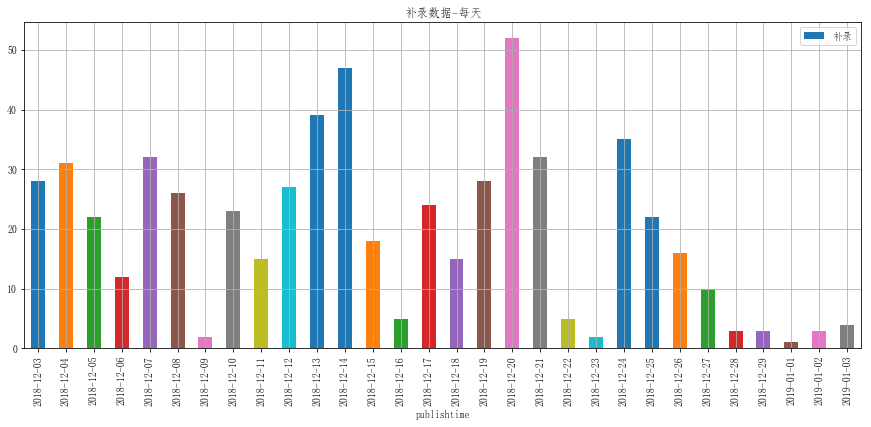

In [18]:
# 补录
apend = circ_cor_count[circ_cor_count['classify'] == '补录'][['publishtime', 'count']]
apend.columns = ['publishtime', '补录']
apend = apend.sort_values(by = 'publishtime', ascending = True)
apend.plot(kind = 'bar', x = 'publishtime', y = '补录', figsize=(15,6), 
           title = '补录数据-每天', grid = True)
apend.sort_values(by = 'publishtime', ascending = False).head()

### class

In [19]:
class_count = pd.concat([circ_cor_count, circ_uncor_count])
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                         \
classify        产品销售   公司内部管理   其他相关报道        噪音     消费服务       监管       行业   
publishtime                                                                   
2019-01-03   566.000  483.000  264.000 24992.000  444.000  898.000 3581.000   
2019-01-02  1143.000 2438.000 1673.000 73061.000 1411.000 2421.000 2374.000   
2019-01-01   310.000  576.000  345.000 35193.000  925.000  866.000  979.000   
2018-12-31   408.000  797.000 1458.000 46042.000  992.000 2298.000 1496.000   
2018-12-30   365.000  709.000  684.000 48994.000 1110.000 1255.000  936.000   

                                  总量       非噪音 非噪音-比例 噪音-比例  
classify       补录     资本市场                                   
publishtime                                                  
2019-01-03  4.000 2576.000 33808.000  8816.000  0.261 0.739  
2019-01-02  3.000 7429.000 91953.000 18892.000  0.205 0.795  
2019-01-01  1.000 3041.000 42236.000  7043.000  0.167 0.833  
2018-12-31    nan 2273.000 55764.000  9722.000  0.174 0.826  
2018-12-30    nan 1481.000 55534.000  6540.000  0.118 0.882

count                                                         \
classify        产品销售   公司内部管理   其他相关报道        噪音     消费服务       监管       行业   
publishtime                                                                   
2019-01-03   566.000  483.000  264.000 24992.000  444.000  898.000 3581.000   
2019-01-02  1143.000 2438.000 1673.000 73061.000 1411.000 2421.000 2374.000   
2019-01-01   310.000  576.000  345.000 35193.000  925.000  866.000  979.000   
2018-12-31   408.000  797.000 1458.000 46042.000  992.000 2298.000 1496.000   
2018-12-30   365.000  709.000  684.000 48994.000 1110.000 1255.000  936.000   

                                  总量  rate                                  \
classify       补录     资本市场            产品销售 公司内部管理 其他相关报道    噪音  消费服务    监管   
publishtime                                                                  
2019-01-03  4.000 2576.000 33808.000 0.017  0.014  0.008 0.739 0.013 0.027   
2019-01-02  3.000 7429.000 91953.000 0.012  0.027  0.018 0.795 0.015 0.026   
2019-01-01  1.000 3041.000 42236.000 0.007  0.014  0.008 0.833 0.022 0.021   
2018-12-31    nan 2273.000 55764.000 0.007  0.014  0.026 0.826 0.018 0.041   
2018-12-30    nan 1481.000 55534.000 0.007  0.013  0.012 0.882 0.020 0.023   

                               
classify       行业    补录  资本市场  
publishtime                    
2019-01-03  0.106 0.000 0.076  
2019-01-02  0.026 0.000 0.081  
2019-01-01  0.023 0.000 0.072  
2018-12-31  0.027   nan 0.041  
2018-12-30  0.017   nan 0.027

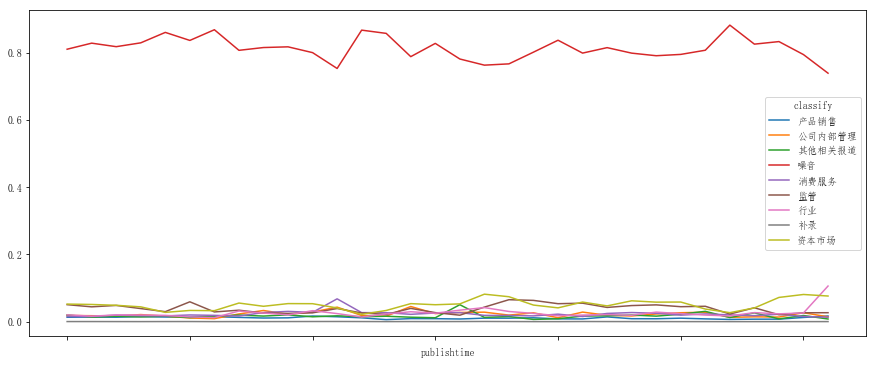

In [20]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

### 总体

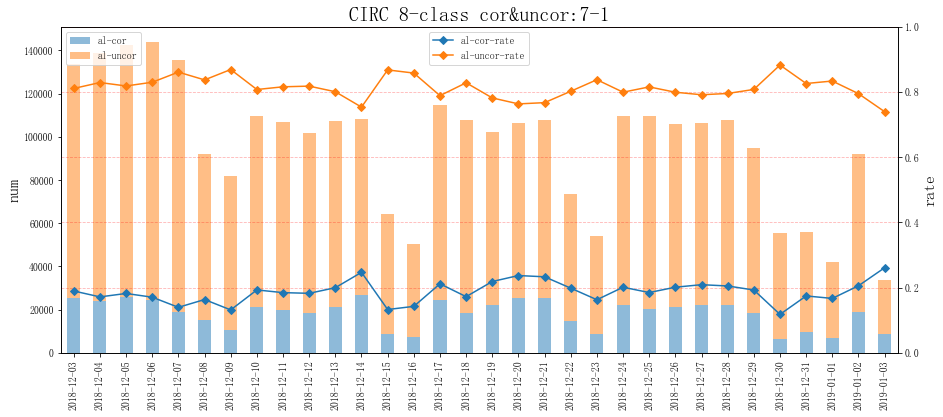

   publishtime       sum    al_cor  al_uncor  al_cor_rate  al_uncor_rate
31  2019-01-03 33808.000  8816.000 24992.000        0.261          0.739
30  2019-01-02 91953.000 18892.000 73061.000        0.205          0.795
29  2019-01-01 42236.000  7043.000 35193.000        0.167          0.833
28  2018-12-31 55764.000  9722.000 46042.000        0.174          0.826
27  2018-12-30 55534.000  6540.000 48994.000        0.118          0.882


In [21]:
plot_cor(count_data_7, circ_day_thing, "CIRC 8-class cor&uncor:7-1")

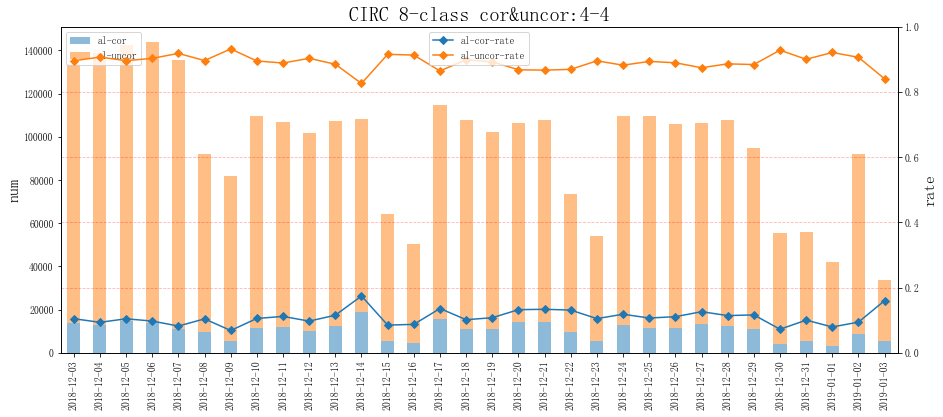

   publishtime  al_uncor       sum   al_cor  al_cor_rate  al_uncor_rate
31  2019-01-03 28398.000 33808.000 5410.000        0.160          0.840
30  2019-01-02 83306.000 91953.000 8647.000        0.094          0.906
29  2019-01-01 38889.000 42236.000 3347.000        0.079          0.921
28  2018-12-31 50181.000 55764.000 5583.000        0.100          0.900
27  2018-12-30 51524.000 55534.000 4010.000        0.072          0.928


In [22]:
plot_cor(count_data_4, circ_day_thing, "CIRC 8-class cor&uncor:4-4")

## 倾向性

In [23]:
sql_tend = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime, t1.tendency, \
                            count(t1.id) as count \
                            from wise_web_docinfo t1 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') \
                                group by date_format(t1.publishtime,'%%Y-%%m-%%d'), t1.tendency \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

tend_count = pd.read_sql(sql_tend, engine)
tend_count.head()

,publishtime,tendency,count
0,2019-01-03,-1,1193
1,2019-01-03,0,7833
2,2019-01-02,-1,2170
3,2019-01-02,0,16750
4,2019-01-01,-1,1646


In [24]:
tend_count[~tend_count['tendency'].isin([-1, 0])].head()

,publishtime,tendency,count
22,2018-12-24,1,4
31,2018-12-20,1,11
34,2018-12-19,1,10
39,2018-12-17,1,6
46,2018-12-14,1,6


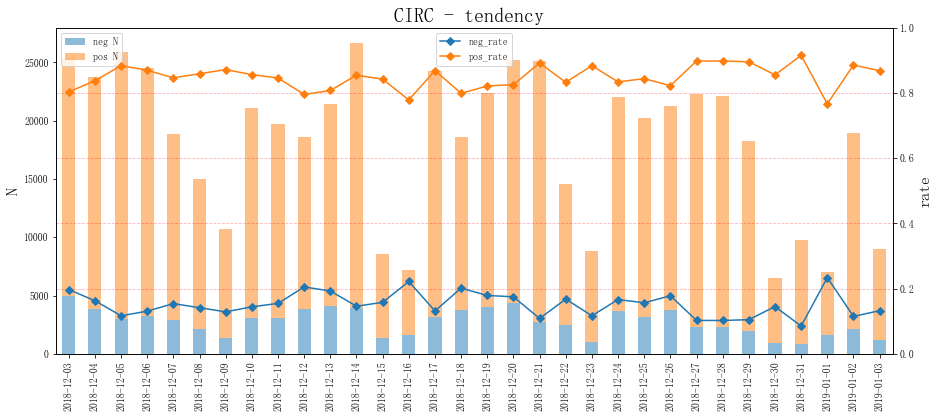

   publishtime   neg    pos    sum  neg_rate  pos_rate
31  2019-01-03  1193   7833   9026     0.132     0.868
30  2019-01-02  2170  16750  18920     0.115     0.885
29  2019-01-01  1646   5398   7044     0.234     0.766
28  2018-12-31   827   8895   9722     0.085     0.915
27  2018-12-30   947   5594   6541     0.145     0.855


In [25]:
tend_count = tend_count[tend_count['tendency'].isin([-1, 0])]
plot_tend(tend_count, circ_day_thing, "CIRC - tendency ")

### group_id

In [26]:
# sql_tend_group = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime, \
#                             t1.tendency, t1.group_id, count(t1.id) as cor_count \
#                             from wise_web_docinfo t1 \
#                                 where (date_format(t1.publishtime, '%%Y-%%m-%%d') >= '{0}' and \
#                                       date_format(t1.publishtime, '%%Y-%%m-%%d') <= '{1}') \
#                                 group by date_format(t1.publishtime,'%%Y-%%m-%%d'), t1.tendency, t1.group_id \
#                                 order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

# tend_group_count = pd.read_sql(sql_tend_group, engine)
# tend_group_count['group_id'] = tend_group_count['group_id'].apply(lambda x: group_dict[str(x)])
# tend_group_count.head()

## 补录和预警

### 一周数据

In [27]:
# add_start_day = '2018-10-27'
# add_end_day = '2018-11-02'

add_start_day = (today - datetime.timedelta(days=8)).strftime("%Y-%m-%d")
add_end_day = (today - datetime.timedelta(days=1)).strftime("%Y-%m-%d")
print('add_start_day：',add_start_day)
print('add_end_day：',add_end_day)

add_start_day： 2018-12-26
add_end_day： 2019-01-02


In [28]:
# 人工补录
sql_human_additional = "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.submited, t1.title, t2.center as content\
                            from wise_web_docinfo t1, wise_web_docinfo_center t2 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.gather_type = 1 ".format(add_start_day, add_end_day) 

human_additional = pd.read_sql(sql_human_additional, engine)
print(human_additional.shape)
# human_additional.head()

(36, 7)


In [29]:
# 预警数据
sql_warning =  "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.submited, t1.title, t2.center as content\
                            from wise_web_docinfo t1, wise_web_docinfo_center t2 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.submited = 1 ".format(add_start_day, add_end_day) 

warning = pd.read_sql(sql_warning, engine)
print(warning.shape)
# warning.head()

(36, 7)


In [30]:
combined_data = pd.concat([human_additional, warning])
print('去重前', combined_data.shape)
combined_data = combined_data.drop_duplicates(subset = 'id')
print('去重后', combined_data.shape)

combined_data['group_id'] = combined_data['group_id'].apply(lambda x:group_dict[str(x)])
combined_data['gather_type'] = combined_data['gather_type'].replace(1, '人工补录').replace(2, '人工修改')
combined_data['submited'] = combined_data['submited'].replace(0, '不预警').replace(1, '预警')

去重前 (72, 7)
去重后 (63, 7)


In [31]:
# predict
data = {"record":combined_data.loc[:,['id', 'title' ,'content']].to_dict(orient = 'records')}
# url = "http://192.168.0.104:11000/judge_correlation_i"
url = "http://47.93.77.19:10000/judge_correlation_i"
parse_data, elapsed_time = get_server_res(data, url)
# parse_data.head()  

parse_data.columns = ['id', 'predict_label']
parse_data['predict_label'] = parse_data['predict_label'].apply(lambda x:class_name_dict[x])
parse_data['label'] = ''
parse_data['cor'] = parse_data['predict_label'].apply(lambda x:1 if x in ['监管', '行业', '经营管理', '消费服务'] else 0)
parse_data['all_cor'] = parse_data['predict_label'].apply(lambda x:1 if x != '噪音' else 0)
parse_data.head()

,id,predict_label,label,cor,all_cor
0,13019021,行业,,1,1
1,13019124,行业,,1,1
2,13019147,监管,,1,1
3,13019175,行业,,1,1
4,13019573,公司内部管理,,0,1


In [32]:
combined_data = pd.merge(combined_data, parse_data, on  = 'id')
stat = combined_data.groupby(['group_id', 'gather_type', 'submited'])['id'].count().reset_index()

# 补录
stat_a = combined_data.groupby(['group_id', 'gather_type'])['id'].count().reset_index()
stat_a = stat_a[stat_a['gather_type'] == '人工补录']

# 补录且预警
stat_a_w = combined_data[combined_data['submited'] == '预警'].groupby(['group_id', 'gather_type'])['id'].count().reset_index()
stat_a_w = stat_a_w[stat_a_w['gather_type'] == '人工补录']

# 预警
stat_w = combined_data.groupby(['group_id', 'submited'])['id'].count().reset_index()
stat_w = stat_w[stat_w['submited'] == '预警']

# 补录-过算法
stat_a_cor = combined_data[combined_data['gather_type'] == '人工补录'].groupby(['group_id', 'cor'])['id'].count().reset_index()
stat_a_cor = stat_a_cor[stat_a_cor['cor'] == 1]

# 补录且预警-过算法
stat_a_w_cor = combined_data[(combined_data['submited'] == '预警') & \
                             (combined_data['gather_type'] == '人工补录')\
                            ].groupby(['group_id', 'cor'])['id'].count().reset_index()
stat_a_w_cor = stat_a_w_cor[stat_a_w_cor['cor'] == 1]

# 补录-过算法
stat_a_cor_7 = combined_data[combined_data['gather_type'] == '人工补录'].groupby(['group_id', 'all_cor'])['id'].count().reset_index()
stat_a_cor_7 = stat_a_cor_7[stat_a_cor_7['all_cor'] == 1]

# 补录且预警-过算法
stat_a_w_cor_7 = combined_data[(combined_data['submited'] == '预警') & \
                             (combined_data['gather_type'] == '人工补录')\
                            ].groupby(['group_id', 'all_cor'])['id'].count().reset_index()
stat_a_w_cor_7 = stat_a_w_cor_7[stat_a_w_cor_7['all_cor'] == 1]

In [33]:
stat_a = stat_a[['group_id', 'id']]
stat_a.columns = ['来源', '补录']
stat_a_w = stat_a_w[['group_id', 'id']]
stat_a_w.columns = ['来源', '补录且预警']
stat_w = stat_w[['group_id', 'id']]
stat_w.columns = ['来源', '预警数量']
stat_a_cor = stat_a_cor[['group_id', 'id']]
stat_a_cor.columns = ['来源', '补录&过算法(4类)']
stat_a_w_cor = stat_a_w_cor[['group_id', 'id']]
stat_a_w_cor.columns = ['来源', '补录且预警&过算法(4类)']
stat_a_cor_7 = stat_a_cor_7[['group_id', 'id']]
stat_a_cor_7.columns = ['来源', '补录&过算法(7类)']
stat_a_w_cor_7 = stat_a_w_cor_7[['group_id', 'id']]
stat_a_w_cor_7.columns = ['来源', '补录且预警&过算法(7类)']

In [34]:
stat = pd.merge(stat_a, stat_w, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_w, on = '来源', how = 'outer')
# stat = pd.merge(stat, stat_a_cor, on = '来源', how = 'outer')
# stat = pd.merge(stat, stat_a_w_cor, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_cor_7, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_w_cor_7, on = '来源', how = 'outer')
stat = stat.set_index('来源').stack().unstack(0)
stat['总量'] =  stat.sum(axis = 1)
stat.loc['补录且预警 / 预警-比例'] = stat.loc['补录且预警'] / stat.loc['预警数量'] 
stat.loc['补录且预警 / 预警-比例'] = stat.loc['补录且预警 / 预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.loc['补录且预警 / 补录-比例'] = stat.loc['补录且预警'] / stat.loc['补录'] 
stat.loc['补录且预警 / 补录-比例'] = stat.loc['补录且预警 / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
# stat.loc['补录&过算法(4类) / 补录-比例'] = stat.loc['补录&过算法(4类)'] / stat.loc['补录'] 
# stat.loc['补录&过算法(4类) / 补录-比例'] = stat.loc['补录&过算法(4类) / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
# stat.loc['补录且预警&过算法(4类) / 预警-比例'] = stat.loc['补录且预警&过算法(4类)'] / stat.loc['预警数量'] 
# stat.loc['补录且预警&过算法(4类) / 预警-比例'] = stat.loc['补录且预警&过算法(4类) / 预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.loc['补录&过算法(7类) / 补录-比例'] = stat.loc['补录&过算法(7类)'] / stat.loc['补录'] 
stat.loc['补录&过算法(7类) / 补录-比例'] = stat.loc['补录&过算法(7类) / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'] = stat.loc['补录且预警&过算法(7类)'] / stat.loc['补录且预警'] 
stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'] = stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.index.name = '保监会：{0} 到 {1}'.format(add_start_day, add_end_day)
stat

来源,微信,新闻,纸媒,总量
保监会：2018-12-26 到 2019-01-02,,,,
补录,5.000,28.000,3.000,36.000
预警数量,4.000,23.000,9.000,36.000
补录且预警,4.000,3.000,2.000,9.000
补录&过算法(7类),5.000,27.000,3.000,35.000
补录且预警&过算法(7类),4.000,3.000,2.000,9.000
补录且预警 / 预警-比例,100%,13%,22%,25%
补录且预警 / 补录-比例,80%,11%,67%,25%
补录&过算法(7类) / 补录-比例,100%,96%,100%,97%
补录且预警&过算法(7类) / 补录且预警-比例,100%,100%,100%,100%


### 导出一段时间补录数据用于训练

In [35]:
# 人工补录
sql_human_additional = "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.submited, t1.title, t2.center as content\
                            from wise_web_docinfo t1, wise_web_docinfo_center t2 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.gather_type = 1 ".format('2018-08-20', '2018-09-16') 

# human_additional = pd.read_sql(sql_human_additional, engine)
# print(human_additional.shape)
# human_additional.head()

In [36]:
# 预警数据
sql_warning =  "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.submited, t1.title, t2.center as content\
                            from wise_web_docinfo t1, wise_web_docinfo_center t2 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.submited = 1 ".format('2018-08-20', '2018-09-16') 

# warning = pd.read_sql(sql_warning, engine)
# print(warning.shape)
# warning.head()

In [37]:
if 0:
    # url = "http://192.168.0.104:11000/judge_correlation_i"
    url = "http://47.93.77.19:10000/judge_correlation_i"
    folder = 'circ_result_class'
    filename = 'circ_add&warning_20180917(0820-0916).xlsx'
    get_period_data_for_training(human_additional, warning, url, folder, filename, 'circ')

# 银行业--旧
- 20191219
  - 八分类：
  - 倾向性：
  - 补录：
- 20191219
  - 八分类：
  - 倾向性：
  - 补录：

## 特殊时间点

In [38]:
engine = specific_func.get_engine('cbrc')

In [39]:
cbrc_day_thing = [['2018-05-02', '相关性模型'], 
             ['2018-06-01', '更新相关性模型'], 
             ['2018-06-12', '更新相关性模型'], 
             ['2018-06-12', '上线倾向性模型']
            ]

## 八分类

In [40]:
sql_cbrc = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime, \
                        t2.traffic_id as classify, count(t1.id) as count \
                            from wise_web_docinfo_basic t1, wise_web_classify_traffic_docinfo t2 \
                                where (date_format(t1.publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(t1.publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t2.base_id=t1.id \
                                group by date_format(t1.publishtime,'%%Y-%%m-%%d'), t2.traffic_id \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

cbrc_count = pd.read_sql(sql_cbrc, engine)
cbrc_count['classify'] = cbrc_count['classify'].apply(lambda x:class_name_dict[x])
cbrc_count.head()

,publishtime,classify,count
0,2019-01-03,监管,1466
1,2019-01-03,行业,6102
2,2019-01-03,产品销售,621
3,2019-01-03,资本市场,6716
4,2019-01-03,公司内部管理,990


### class

In [41]:
class_count = cbrc_count
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                      总量  \
classify     产品销售 公司内部管理 其他相关报道     噪音   消费服务    监管     行业   资本市场           
publishtime                                                                 
2019-01-03    621    990   1843  32113   3003  1466   6102   6716   52854   
2019-01-02   1899   3646   3716  75600  10574  5158  11766  16759  129118   
2019-01-01   1685   1598   9972  36442   3721  1531   5814   8080   68843   
2018-12-31    783    983   2112  41832   4090  2562   6365  11516   70243   
2018-12-30    997   2473   2823  47027   5682  2081   6628   5682   73393   

               非噪音 非噪音-比例 噪音-比例  
classify                         
publishtime                      
2019-01-03   20741  0.392 0.608  
2019-01-02   53518  0.414 0.586  
2019-01-01   32401  0.471 0.529  
2018-12-31   28411  0.404 0.596  
2018-12-30   26366  0.359 0.641

count                                                      总量  \
classify     产品销售 公司内部管理 其他相关报道     噪音   消费服务    监管     行业   资本市场           
publishtime                                                                 
2019-01-03    621    990   1843  32113   3003  1466   6102   6716   52854   
2019-01-02   1899   3646   3716  75600  10574  5158  11766  16759  129118   
2019-01-01   1685   1598   9972  36442   3721  1531   5814   8080   68843   
2018-12-31    783    983   2112  41832   4090  2562   6365  11516   70243   
2018-12-30    997   2473   2823  47027   5682  2081   6628   5682   73393   

             rate                                              
classify     产品销售 公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场  
publishtime                                                    
2019-01-03  0.012  0.019  0.035 0.608 0.057 0.028 0.115 0.127  
2019-01-02  0.015  0.028  0.029 0.586 0.082 0.040 0.091 0.130  
2019-01-01  0.024  0.023  0.145 0.529 0.054 0.022 0.084 0.117  
2018-12-31  0.011  0.014  0.030 0.596 0.058 0.036 0.091 0.164  
2018-12-30  0.014  0.034  0.038 0.641 0.077 0.028 0.090 0.077

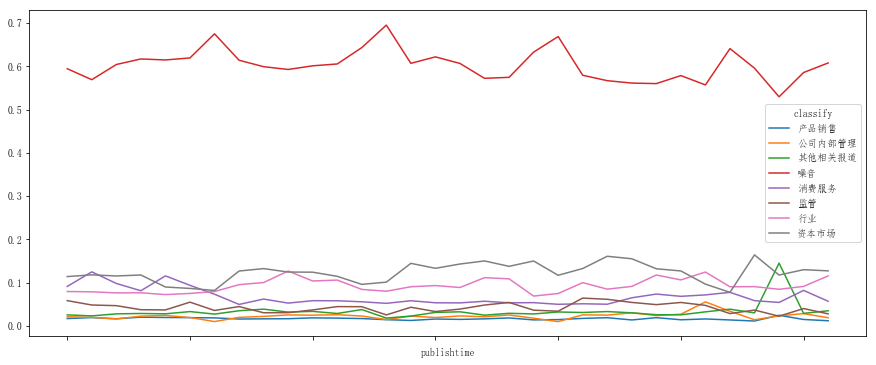

In [42]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

### 总体

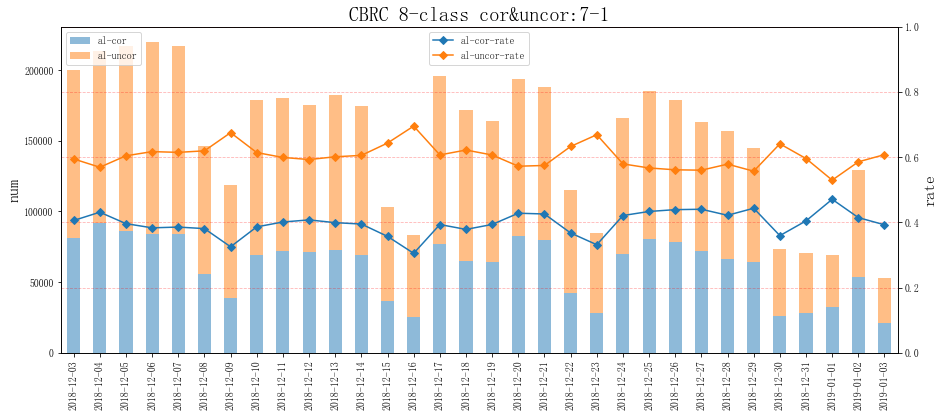

   publishtime     sum  al_cor  al_uncor  al_cor_rate  al_uncor_rate
31  2019-01-03   52854   20741     32113        0.392          0.608
30  2019-01-02  129118   53518     75600        0.414          0.586
29  2019-01-01   68843   32401     36442        0.471          0.529
28  2018-12-31   70243   28411     41832        0.404          0.596
27  2018-12-30   73393   26366     47027        0.359          0.641


In [43]:
plot_cor(count_data_7, cbrc_day_thing, "CBRC 8-class cor&uncor:7-1")

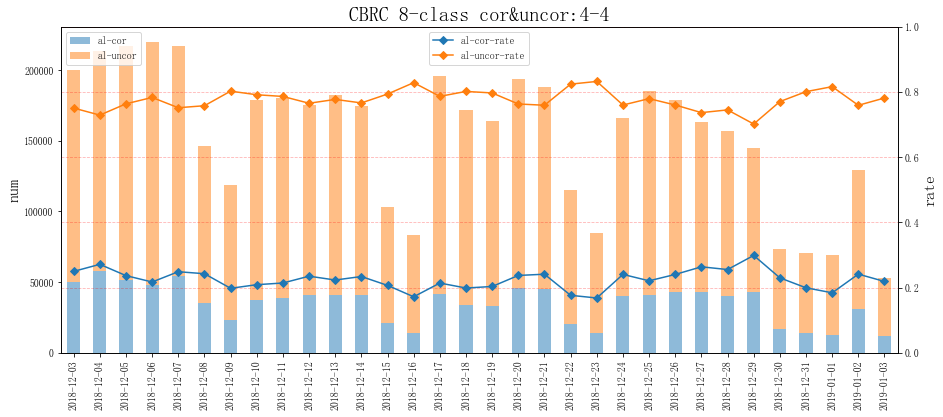

   publishtime  al_uncor     sum  al_cor  al_cor_rate  al_uncor_rate
31  2019-01-03     41293   52854   11561        0.219          0.781
30  2019-01-02     97974  129118   31144        0.241          0.759
29  2019-01-01     56179   68843   12664        0.184          0.816
28  2018-12-31     56243   70243   14000        0.199          0.801
27  2018-12-30     56529   73393   16864        0.230          0.770


In [44]:
plot_cor(count_data_4, cbrc_day_thing, "CBRC 8-class cor&uncor:4-4")

## 倾向性

In [45]:
sql_tend = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime, t1.sen as tendency, count(t1.id) as cor_count \
                            from elint_web_docinfo t1 \
                                where (date_format(t1.publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(t1.publishtime, '%%Y-%%m-%%d') <= '{1}') \
                                group by date_format(t1.publishtime,'%%Y-%%m-%%d'), t1.sen \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

tend_count = pd.read_sql(sql_tend, engine)
tend_count = tend_count[tend_count['tendency'] != 1]
tend_count.head()

,publishtime,tendency,cor_count
0,2019-01-03,-1,2460
1,2019-01-03,0,9368
3,2019-01-02,-1,8307
4,2019-01-02,0,23537
6,2019-01-01,-1,2556


In [46]:
tend_count[tend_count['tendency'].isin([-1, 0])].head()

,publishtime,tendency,cor_count
0,2019-01-03,-1,2460
1,2019-01-03,0,9368
3,2019-01-02,-1,8307
4,2019-01-02,0,23537
6,2019-01-01,-1,2556


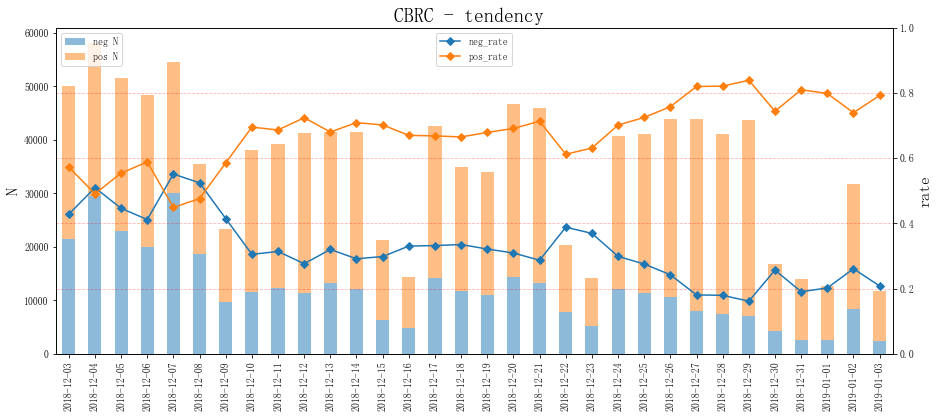

   publishtime   neg    pos    sum  neg_rate  pos_rate
31  2019-01-03  2460   9368  11828     0.208     0.792
30  2019-01-02  8307  23537  31844     0.261     0.739
29  2019-01-01  2556  10111  12667     0.202     0.798
28  2018-12-31  2666  11333  13999     0.190     0.810
27  2018-12-30  4326  12538  16864     0.257     0.743


In [47]:
tend_count = tend_count[tend_count['tendency'].isin([-1, 0])]
plot_tend(tend_count, cbrc_day_thing, "CBRC - tendency ")

## 补录和预警

### 补录数据

In [48]:
sql_human_additional = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, count(t1.id) as count \
                            from elint_web_docinfo t1 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.gather_type = 1 \
                                group by date_format(t1.publishtime,'%%Y-%%m-%%d') \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

human_additional_count = pd.read_sql(sql_human_additional, engine)
human_additional_count.sort_values(by = 'publishtime', ascending = False).head()

,publishtime,gather_type,count
0,2019-01-03,1,2
1,2019-01-02,1,29
2,2019-01-01,1,3
3,2018-12-31,1,1
4,2018-12-29,1,7


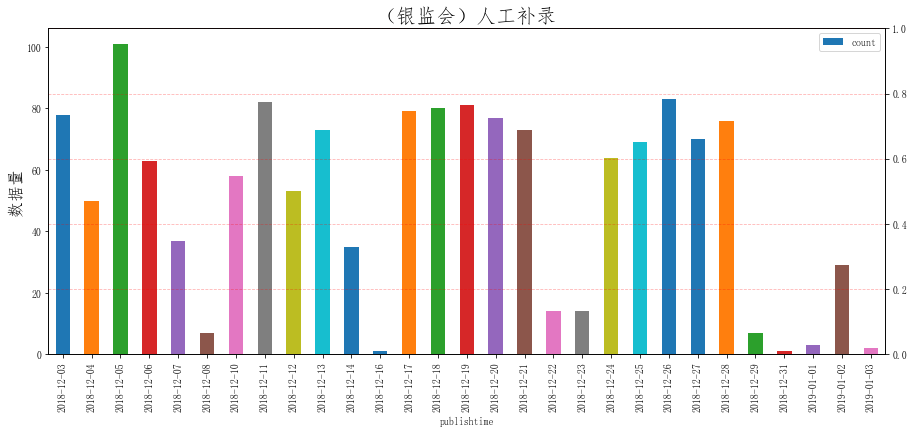

,publishtime,gather_type,count
0,2019-01-03,1,2
1,2019-01-02,1,29
2,2019-01-01,1,3
3,2018-12-31,1,1
4,2018-12-29,1,7


In [49]:
human_additional_count = human_additional_count.sort_values(by = 'publishtime')
fig = plt.figure(figsize = (15,6))
ax1 = fig.add_subplot(111)
human_additional_count.plot(x = 'publishtime', y = 'count', kind = 'bar', figsize = (15, 6), ax = ax1)
ax1.set_ylabel('数据量', fontsize = 16)
ax1.set_title("（银监会）人工补录", fontsize = 20)

ax2 = ax1.twinx()  # this is the important function
ax2.set_ylim(0, 1)
y_list = [0.65, 0.75, 0.85, 0.95]
m = 0
for [d, t] in cbrc_day_thing:    
    if d in human_additional_count['publishtime'].tolist():
        x = human_additional_count['publishtime'].tolist().index(d)
        ax2.axvline(x=x, ymin = y_list[m] - 0.1, ymax = y_list[m] + 0.1, 
                    color='k', linestyle = "--", alpha = 0.75)
        ax2.text(x - 0.25, y_list[m], t, va='center', fontsize = 12)
        if m == 3: 
            m = 0
        else :
            m += 1
        
plt.grid(True, linestyle = "--", color = "r", alpha = 0.3) 
plt.show()

human_additional_count.sort_values(by = 'publishtime', ascending = False).head()

### 一周数据

In [50]:
# add_start_day = '2018-10-27'
# add_end_day = '2018-11-02'

add_start_day = (today - datetime.timedelta(days=8)).strftime("%Y-%m-%d")
add_end_day = (today - datetime.timedelta(days=1)).strftime("%Y-%m-%d")
print('add_start_day：',add_start_day)
print('add_end_day：',add_end_day)

add_start_day： 2018-12-26
add_end_day： 2019-01-02


In [51]:
# 人工补录
sql_human_additional = "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.sec, t1.title, t2.text as content\
                            from elint_web_docinfo t1, wise_web_docinfo_text t2\
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.gather_type = 1 ".format(add_start_day, add_end_day) 

human_additional = pd.read_sql(sql_human_additional, engine)
print(human_additional.shape)
# human_additional.head()

(269, 7)


In [52]:
# 预警数据
sql_warning =  "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.sec, t1.title, t2.text as content\
                            from elint_web_docinfo t1, wise_web_docinfo_text t2\
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.sec in (7,8,9) ".format(add_start_day, add_end_day)  

warning = pd.read_sql(sql_warning, engine)
print(warning.shape)
# warning.head()

(783, 7)


In [53]:
combined_data = pd.concat([human_additional, warning])
print('去重前', combined_data.shape)
combined_data = combined_data.drop_duplicates(subset = 'id')
print('去重后', combined_data.shape)

combined_data['group_id'] = combined_data['group_id'].apply(lambda x:group_dict[str(x)])
combined_data['gather_type'] = combined_data['gather_type'].replace(0, '系统采集').replace(1, '人工补录').replace(2, '人工修改')
combined_data['submited'] = combined_data['sec'].apply(lambda x: '预警' if x in [7,8,9] else '不预警')
# combined_data.head()

去重前 (1052, 7)
去重后 (787, 7)


In [54]:
combined_data.groupby(['gather_type', 'group_id', 'submited'])['id'].count()

gather_type  group_id  submited
4            微博        预警          211
人工修改         外媒        预警            2
             微博        预警          142
             新闻        预警           90
             纸媒        预警           47
             论坛        预警           26
人工补录         微信        预警            3
             微博        不预警           1
                       预警          241
             新闻        不预警           3
                       预警           19
             纸媒        预警            2
Name: id, dtype: int64

In [55]:
# predict
data = {"record":combined_data.loc[:,['id', 'title' ,'content']].to_dict(orient = 'records')}
# url = "http://192.168.0.104:11000/judge_correlation_yjh"
url = "http://47.93.77.19:6001/judge_correlation_yjh"
parse_data = get_server_res_yjh(data, url, 'sec')
# parse_data.head()  

parse_data.columns = ['id', 'predict_label']
parse_data['predict_label'] = parse_data['predict_label'].apply(lambda x:class_name_dict[x])
parse_data['label'] = ''
parse_data['cor'] = parse_data['predict_label'].apply(lambda x:1 if x in ['监管', '行业', '经营管理', '消费服务'] else 0)
parse_data['all_cor'] = parse_data['predict_label'].apply(lambda x:1 if x != '噪音' else 0)
parse_data.head()

,id,predict_label,label,cor,all_cor
0,273517493,消费服务,,1,1
1,273517601,消费服务,,1,1
2,273517602,消费服务,,1,1
3,273518202,消费服务,,1,1
4,273518205,消费服务,,1,1


In [56]:
combined_data = pd.merge(combined_data, parse_data, on  = 'id')
stat = combined_data.groupby(['group_id', 'gather_type', 'submited'])['id'].count().reset_index()

# 补录
stat_a = combined_data.groupby(['group_id', 'gather_type'])['id'].count().reset_index()
stat_a = stat_a[stat_a['gather_type'] == '人工补录']

# 补录且预警
stat_a_w = combined_data[combined_data['submited'] == '预警'].groupby(['group_id', 'gather_type'])['id'].count().reset_index()
stat_a_w = stat_a_w[stat_a_w['gather_type'] == '人工补录']

# 预警
stat_w = combined_data.groupby(['group_id', 'submited'])['id'].count().reset_index()
stat_w = stat_w[stat_w['submited'] == '预警']

# 补录-过算法
stat_a_cor = combined_data[combined_data['gather_type'] == '人工补录'].groupby(['group_id', 'cor'])['id'].count().reset_index()
stat_a_cor = stat_a_cor[stat_a_cor['cor'] == 1]

# 补录且预警-过算法
stat_a_w_cor = combined_data[(combined_data['submited'] == '预警') & \
                             (combined_data['gather_type'] == '人工补录')\
                            ].groupby(['group_id', 'cor'])['id'].count().reset_index()
stat_a_w_cor = stat_a_w_cor[stat_a_w_cor['cor'] == 1]

# 补录-过算法
stat_a_cor_7 = combined_data[combined_data['gather_type'] == '人工补录'].groupby(['group_id', 'all_cor'])['id'].count().reset_index()
stat_a_cor_7 = stat_a_cor_7[stat_a_cor_7['all_cor'] == 1]

# 补录且预警-过算法
stat_a_w_cor_7 = combined_data[(combined_data['submited'] == '预警') & \
                             (combined_data['gather_type'] == '人工补录')\
                            ].groupby(['group_id', 'all_cor'])['id'].count().reset_index()
stat_a_w_cor_7 = stat_a_w_cor_7[stat_a_w_cor_7['all_cor'] == 1]

In [57]:
stat_a = stat_a[['group_id', 'id']]
stat_a.columns = ['来源', '补录']
stat_a_w = stat_a_w[['group_id', 'id']]
stat_a_w.columns = ['来源', '补录且预警']
stat_w = stat_w[['group_id', 'id']]
stat_w.columns = ['来源', '预警数量']
stat_a_cor = stat_a_cor[['group_id', 'id']]
stat_a_cor.columns = ['来源', '补录&过算法(4类)']
stat_a_w_cor = stat_a_w_cor[['group_id', 'id']]
stat_a_w_cor.columns = ['来源', '补录且预警&过算法(4类)']
stat_a_cor_7 = stat_a_cor_7[['group_id', 'id']]
stat_a_cor_7.columns = ['来源', '补录&过算法(7类)']
stat_a_w_cor_7 = stat_a_w_cor_7[['group_id', 'id']]
stat_a_w_cor_7.columns = ['来源', '补录且预警&过算法(7类)']

In [58]:
stat

,group_id,gather_type,submited,id
0,外媒,人工修改,预警,2
1,微信,人工补录,预警,3
2,微博,4,预警,211
3,微博,人工修改,预警,142
4,微博,人工补录,不预警,1
5,微博,人工补录,预警,241
6,新闻,人工修改,预警,90
7,新闻,人工补录,不预警,3
8,新闻,人工补录,预警,19
9,纸媒,人工修改,预警,47


In [59]:
stat = pd.merge(stat_a, stat_w, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_w, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_cor, on = '来源')
stat = pd.merge(stat, stat_a_w_cor, on = '来源')
stat = pd.merge(stat, stat_a_cor_7, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_w_cor_7, on = '来源', how = 'outer')
stat = stat.set_index('来源').stack().unstack(0)
stat = stat.fillna(0)
stat['总量'] =  stat.sum(axis = 1)
stat.loc['补录且预警 / 预警-比例'] = stat.loc['补录且预警'] / stat.loc['预警数量'] 
stat.loc['补录且预警 / 预警-比例'] = stat.loc['补录且预警 / 预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
# stat.loc['补录且预警 / 补录-比例'] = stat.loc['补录且预警'] / stat.loc['补录'] 
# stat.loc['补录且预警 / 补录-比例'] = stat.loc['补录且预警 / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.loc['补录&过算法(4类) / 补录-比例'] = stat.loc['补录&过算法(4类)'] / stat.loc['补录'] 
stat.loc['补录&过算法(4类) / 补录-比例'] = stat.loc['补录&过算法(4类) / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
# stat.loc['补录且预警&过算法(4类) / 预警-比例'] = stat.loc['补录且预警&过算法(4类)'] / stat.loc['预警数量'] 
# stat.loc['补录且预警&过算法(4类) / 预警-比例'] = stat.loc['补录且预警&过算法(4类) / 预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.loc['补录&过算法(7类) / 补录-比例'] = stat.loc['补录&过算法(7类)'] / stat.loc['补录'] 
stat.loc['补录&过算法(7类) / 补录-比例'] = stat.loc['补录&过算法(7类) / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
# stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'] = stat.loc['补录且预警&过算法(7类)'] / stat.loc['补录且预警'] 
# stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'] = stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.index.name = '保监会：{0} 到 {1}'.format(add_start_day, add_end_day)
stat.fillna(0)

来源,微信,微博,新闻,纸媒,总量
保监会：2018-12-26 到 2019-01-02,,,,,
补录,3.000,242.000,22.000,2.000,269.000
预警数量,3.000,594.000,109.000,49.000,755.000
补录且预警,3.000,241.000,19.000,2.000,265.000
补录&过算法(4类),1.000,240.000,7.000,2.000,250.000
补录且预警&过算法(4类),1.000,239.000,6.000,2.000,248.000
补录&过算法(7类),2.000,242.000,18.000,2.000,264.000
补录且预警&过算法(7类),2.000,241.000,17.000,2.000,262.000
补录且预警 / 预警-比例,100%,41%,17%,4%,35%
补录&过算法(4类) / 补录-比例,33%,99%,32%,100%,93%


### 导出一段时间补录数据用于训练

In [60]:
# 人工补录
sql_human_additional = "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.sec, t1.title, t2.text as content\
                            from elint_web_docinfo t1, wise_web_docinfo_text t2\
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.gather_type = 1 ".format('2018-08-20', '2018-09-16') 

# human_additional = pd.read_sql(sql_human_additional, engine)
# print(human_additional.shape)
# human_additional.head()

In [61]:
# 预警数据
sql_warning =  "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.sec, t1.title, t2.text as content\
                            from elint_web_docinfo t1, wise_web_docinfo_text t2\
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.sec in (7,8,9) ".format('2018-08-20', '2018-09-16') 

# warning = pd.read_sql(sql_warning, engine)
# print(warning.shape)
# warning.head()

In [62]:
if 0:
    # url = "http://192.168.0.104:11000/judge_correlation_yjh"
    url = "http://47.93.77.19:6001/judge_correlation_yjh"
    folder = 'cbrc_result_class'
    filename = 'cbrc_add&warning_20180917(0820-0916).xlsx'
    get_period_data_for_training(human_additional, warning, url, folder, filename, 'cbrc')

# 安徽银监局
- 20191219
  - 八分类：
  - 倾向性：
  - 补录：
- 20191219
  - 八分类：
  - 倾向性：
  - 补录：

## 特殊时间点

In [63]:
engine = specific_func.get_engine('ahyjj')

In [64]:
cbirc_day_thing = [['2018-05-02', '相关性模型'], 
             ['2018-06-01', '更新相关性模型'], 
             ['2018-06-12', '更新相关性模型'], 
             ['2018-06-12', '上线倾向性模型']
            ]

In [65]:
start_day = today - datetime.timedelta(days=32) # 30 天
start_day = start_day.strftime("%Y-%m-%d") # '2018-08-12'  # 含
end_day = yesterday_str    # 含
print('start_day：',start_day)
print('end_day：',end_day)

# day_select = '2018-09-09'
day_list = get_day_list(start_day, end_day)
print(day_list)
len(day_list)

start_day： 2018-12-02
end_day： 2019-01-02
['2018-12-03', '2018-12-04', '2018-12-05', '2018-12-06', '2018-12-07', '2018-12-08', '2018-12-09', '2018-12-10', '2018-12-11', '2018-12-12', '2018-12-13', '2018-12-14', '2018-12-15', '2018-12-16', '2018-12-17', '2018-12-18', '2018-12-19', '2018-12-20', '2018-12-21', '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25', '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29', '2018-12-30', '2018-12-31', '2019-01-01', '2019-01-02']


31

## 获取数据

In [67]:
for t in range(6, 7):
    print('获取 %s 的数据 -------'%(proj_name_dict[t]))
    for day in day_list:
        filename = 'result/statistics_result/mysql_daily_count_by_condition/%s_%s_mysql_stat.xlsx'%(proj_name_dict[t], day)
        if os.path.exists(filename):
            print('   已存在：', filename)
        else :
            t0 = time.time()
            sql_cbirc = '''
            SELECT
                t2.type,
                t1.traffic_id AS classify,
                t2.sen as tendency, 
                COUNT(t1.id) AS count,
                t2.gather_type,
                t3.group_id,
                t2.sec
            FROM
                db_classify_traffic_docinfo t1
                    LEFT JOIN
                db_docinfo_trade t2 ON t1.urlhash = t2.urlhash
                    LEFT JOIN
                db_docinfo t3 ON t2.urlhash = t3.urlhash
            WHERE
                t3.publishtime >= '{0} 00:00:00'
                AND t3.publishtime <= '{0} 23:59:59'
                    and t2.type = {1}
                    and t1.type = t2.type
            GROUP BY t2.gather_type, t2.type , t1.traffic_id, t3.group_id, t2.sen, t2.sec
            '''.format(day, 1)

            cbirc_count_type = pd.read_sql(sql_cbirc, engine)     
            cbirc_count_type['publishtime'] = day
            cbirc_count_type.to_excel(filename, index = False)    
            print('   日期：%s ；耗时：%s s'%(day, time.time() - t0))
            print('   已生成：', filename)

获取 安徽银监局 的数据 -------
   已存在： result/statistics_result/mysql_daily_count_by_condition/安徽银监局_2018-12-03_mysql_stat.xlsx
   已存在： result/statistics_result/mysql_daily_count_by_condition/安徽银监局_2018-12-04_mysql_stat.xlsx
   已存在： result/statistics_result/mysql_daily_count_by_condition/安徽银监局_2018-12-05_mysql_stat.xlsx
   已存在： result/statistics_result/mysql_daily_count_by_condition/安徽银监局_2018-12-06_mysql_stat.xlsx
   已存在： result/statistics_result/mysql_daily_count_by_condition/安徽银监局_2018-12-07_mysql_stat.xlsx
   已存在： result/statistics_result/mysql_daily_count_by_condition/安徽银监局_2018-12-08_mysql_stat.xlsx
   已存在： result/statistics_result/mysql_daily_count_by_condition/安徽银监局_2018-12-09_mysql_stat.xlsx
   已存在： result/statistics_result/mysql_daily_count_by_condition/安徽银监局_2018-12-10_mysql_stat.xlsx
   已存在： result/statistics_result/mysql_daily_count_by_condition/安徽银监局_2018-12-11_mysql_stat.xlsx
   已存在： result/statistics_result/mysql_daily_count_by_condition/安徽银监局_2018-12-12_mysql_stat.xlsx
   已存在： r

In [68]:
cbirc_count_all = pd.DataFrame()
for t in range(6, 7):
#     print('获取 %s 的数据 -------'%(proj_name_dict[t]))
    for day in day_list:
        filename = 'result/statistics_result/mysql_daily_count_by_condition/%s_%s_mysql_stat.xlsx'%(proj_name_dict[t], day)
        if os.path.exists(filename):
            cbirc_count_type = pd.read_excel(filename)
            cbirc_count_all = pd.concat([cbirc_count_all, cbirc_count_type], axis = 0)
        else :
            print('   不存在：', filename)

In [69]:
# cbirc_count_all.rename(columns={'publistime': 'publishtime'}, inplace=True) 
print(cbirc_count_all.shape)
cbirc_count_all.head()

(1391, 8)


,type,classify,tendency,count,gather_type,group_id,sec,publishtime
0,1,1,0,18,0,1,4,2018-12-03
1,1,1,-1,1,0,11,4,2018-12-03
2,1,1,0,44,0,11,4,2018-12-03
3,1,1,-1,1,0,13,4,2018-12-03
4,1,1,0,2,0,13,4,2018-12-03


### 八分类数据

In [70]:
cbirc_count = cbirc_count_all.groupby(['publishtime', 'type', 'classify'])['count'].sum()
cbirc_count = cbirc_count.reset_index(['publishtime', 'type', 'classify'])
cbirc_count.head()

,publishtime,type,classify,count
0,2018-12-03,1,1,66
1,2018-12-03,1,2,409
2,2018-12-03,1,3,20
3,2018-12-03,1,4,106
4,2018-12-03,1,5,67


In [71]:
cbirc_count['classify'] = cbirc_count['classify'].apply(lambda x:class_name_dict[int(x)])
cbirc_count['type'] = cbirc_count['type'].apply(lambda x:proj_name_dict[int(6)])
print(cbirc_count.shape)
print(cbirc_count.info(memory_usage = 'deep'))
# cbirc_count.head()

print(cbirc_count['count'].sum())
cbirc_count.pivot_table(index = ['publishtime'], columns = ['type'], 
                        aggfunc = [np.sum], values = ['count'], 
                        fill_value = 0, margins = True)

(245, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 4 columns):
publishtime    245 non-null object
type           245 non-null object
classify       245 non-null object
count          245 non-null int64
dtypes: int64(1), object(3)
memory usage: 64.4 KB
None
26250


sum       
             count       
type         安徽银监局    All
publishtime              
2018-12-03    2335   2335
2018-12-04    2149   2149
2018-12-05    1421   1421
2018-12-06    2210   2210
2018-12-07    2774   2774
2018-12-08    1225   1225
2018-12-09     896    896
2018-12-10    1154   1154
2018-12-11    1448   1448
2018-12-12     980    980
2018-12-13     682    682
2018-12-14     618    618
2018-12-15     254    254
2018-12-16     275    275
2018-12-17    1112   1112
2018-12-18     554    554
2018-12-19     456    456
2018-12-20     671    671
2018-12-21     525    525
2018-12-22     139    139
2018-12-23      60     60
2018-12-24     318    318
2018-12-25     733    733
2018-12-26     648    648
2018-12-27     553    553
2018-12-28     397    397
2018-12-29     539    539
2018-12-30     172    172
2018-12-31     130    130
2019-01-01     177    177
2019-01-02     645    645
All          26250  26250

### 倾向性数据

In [72]:
tend_count = cbirc_count_all.groupby(['publishtime', 'type', 'tendency'])['count'].sum()
tend_count = tend_count.reset_index(['publishtime', 'type', 'tendency'])
tend_count.head()

,publishtime,type,tendency,count
0,2018-12-03,1,-1,200
1,2018-12-03,1,0,2135
2,2018-12-04,1,-1,217
3,2018-12-04,1,0,1932
4,2018-12-05,1,-1,95


In [73]:
# cor_list = ['产品销售', '资本市场', '其他相关报道', '噪音'] # 3、4、7、8
cor_list = [3,4,7,8]
tend_count_4 = cbirc_count_all[~cbirc_count_all['classify'].isin(cor_list)].groupby(['publishtime', 'type', 'tendency'])['count'].sum()
tend_count_4 = tend_count_4.reset_index(['publishtime', 'type', 'tendency'])
tend_count_4['type'] = tend_count_4['type'].apply(lambda x:proj_name_dict[int(6)])
tend_count_4.head()

,publishtime,type,tendency,count
0,2018-12-03,安徽银监局,-1,200
1,2018-12-03,安徽银监局,0,1424
2,2018-12-04,安徽银监局,-1,217
3,2018-12-04,安徽银监局,0,650
4,2018-12-05,安徽银监局,-1,95


In [74]:
tend_count['type'] = tend_count['type'].apply(lambda x:proj_name_dict[int(6)])
print(tend_count.shape)
print(tend_count.info(memory_usage = 'deep'))
# tend_count.head()

print(tend_count['count'].sum())
tend_count.pivot_table(index = ['publishtime'], columns = ['type'], 
                        aggfunc = [np.sum], values = ['count'], 
                        fill_value = 0, margins = True)

(62, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 4 columns):
publishtime    62 non-null object
type           62 non-null object
tendency       62 non-null int64
count          62 non-null int64
dtypes: int64(2), object(2)
memory usage: 11.6 KB
None
26250


sum       
             count       
type         安徽银监局    All
publishtime              
2018-12-03    2335   2335
2018-12-04    2149   2149
2018-12-05    1421   1421
2018-12-06    2210   2210
2018-12-07    2774   2774
2018-12-08    1225   1225
2018-12-09     896    896
2018-12-10    1154   1154
2018-12-11    1448   1448
2018-12-12     980    980
2018-12-13     682    682
2018-12-14     618    618
2018-12-15     254    254
2018-12-16     275    275
2018-12-17    1112   1112
2018-12-18     554    554
2018-12-19     456    456
2018-12-20     671    671
2018-12-21     525    525
2018-12-22     139    139
2018-12-23      60     60
2018-12-24     318    318
2018-12-25     733    733
2018-12-26     648    648
2018-12-27     553    553
2018-12-28     397    397
2018-12-29     539    539
2018-12-30     172    172
2018-12-31     130    130
2019-01-01     177    177
2019-01-02     645    645
All          26250  26250

### 预警与补录数据

In [75]:
cbirc_add = cbirc_count_all.groupby(['publishtime', 'type', 'gather_type'])['count'].sum()
cbirc_add = cbirc_add.reset_index(['publishtime', 'type', 'gather_type'])
cbirc_add = cbirc_add[cbirc_add['gather_type'].isin([1,3])]
cbirc_add.head()

,publishtime,type,gather_type,count


In [76]:
# # cbirc_add['gather_type'] = cbirc_add['gather_type'].apply(lambda x:group_dict[str(x)])
# cbirc_add['type'] = cbirc_add['type'].apply(lambda x:proj_name_dict[int(6)])
# print(cbirc_add.shape)
# print(cbirc_add.info(memory_usage = 'deep'))
# # cbirc_count.head()

# print(cbirc_add['count'].sum())
# cbirc_add.pivot_table(index = ['publishtime'], columns = ['type', 'gather_type'], 
#                         aggfunc = [np.sum], values = ['count'], 
#                         fill_value = 0, margins = True)

## 八分类

In [77]:
class_count = cbirc_count[cbirc_count['type'] == '安徽银监局'].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                          总量  \
classify     产品销售  公司内部管理 其他相关报道     噪音   消费服务     监管      行业    资本市场           
publishtime                                                                     
2019-01-02  4.000 102.000 40.000 43.000 40.000  8.000 176.000 232.000 645.000   
2019-01-01  2.000  40.000  6.000 10.000 15.000    nan  37.000  67.000 177.000   
2018-12-31  3.000  13.000  2.000 10.000 38.000 31.000  28.000   5.000 130.000   
2018-12-30  1.000  33.000  2.000 37.000 30.000  4.000  47.000  18.000 172.000   
2018-12-29  5.000  73.000 66.000 37.000 86.000 14.000 204.000  54.000 539.000   

                非噪音 非噪音-比例 噪音-比例  
classify                          
publishtime                       
2019-01-02  602.000  0.933 0.067  
2019-01-01  167.000  0.944 0.056  
2018-12-31  120.000  0.923 0.077  
2018-12-30  135.000  0.785 0.215  
2018-12-29  502.000  0.931 0.069

count                                                          总量  \
classify     产品销售  公司内部管理 其他相关报道     噪音   消费服务     监管      行业    资本市场           
publishtime                                                                     
2019-01-02  4.000 102.000 40.000 43.000 40.000  8.000 176.000 232.000 645.000   
2019-01-01  2.000  40.000  6.000 10.000 15.000    nan  37.000  67.000 177.000   
2018-12-31  3.000  13.000  2.000 10.000 38.000 31.000  28.000   5.000 130.000   
2018-12-30  1.000  33.000  2.000 37.000 30.000  4.000  47.000  18.000 172.000   
2018-12-29  5.000  73.000 66.000 37.000 86.000 14.000 204.000  54.000 539.000   

             rate                                              
classify     产品销售 公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场  
publishtime                                                    
2019-01-02  0.006  0.158  0.062 0.067 0.062 0.012 0.273 0.360  
2019-01-01  0.011  0.226  0.034 0.056 0.085   nan 0.209 0.379  
2018-12-31  0.023  0.100  0.015 0.077 0.292 0.238 0.215 0.038  
2018-12-30  0.006  0.192  0.012 0.215 0.174 0.023 0.273 0.105  
2018-12-29  0.009  0.135  0.122 0.069 0.160 0.026 0.378 0.100

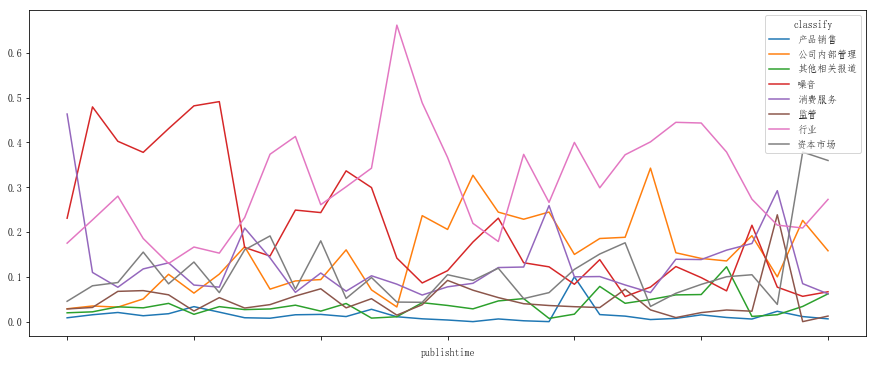

In [78]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

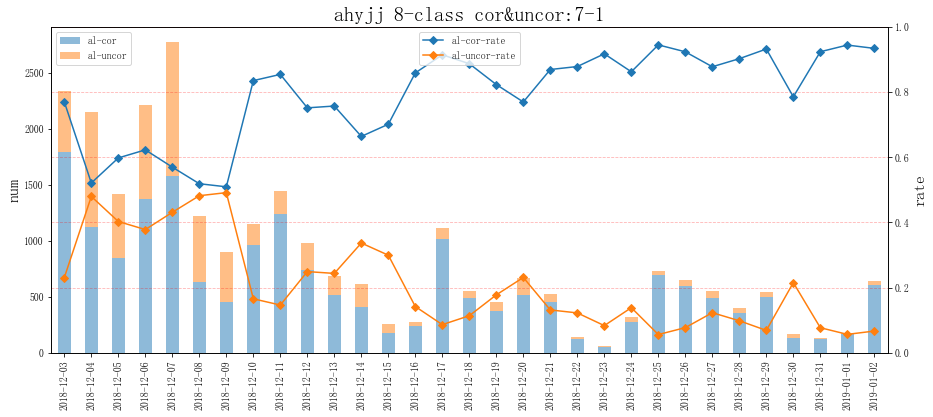

   publishtime     sum  al_cor  al_uncor  al_cor_rate  al_uncor_rate
30  2019-01-02 645.000 602.000    43.000        0.933          0.067
29  2019-01-01 177.000 167.000    10.000        0.944          0.056
28  2018-12-31 130.000 120.000    10.000        0.923          0.077
27  2018-12-30 172.000 135.000    37.000        0.785          0.215
26  2018-12-29 539.000 502.000    37.000        0.931          0.069


In [79]:
plot_cor(count_data_7, cbirc_day_thing, "ahyjj 8-class cor&uncor:7-1")

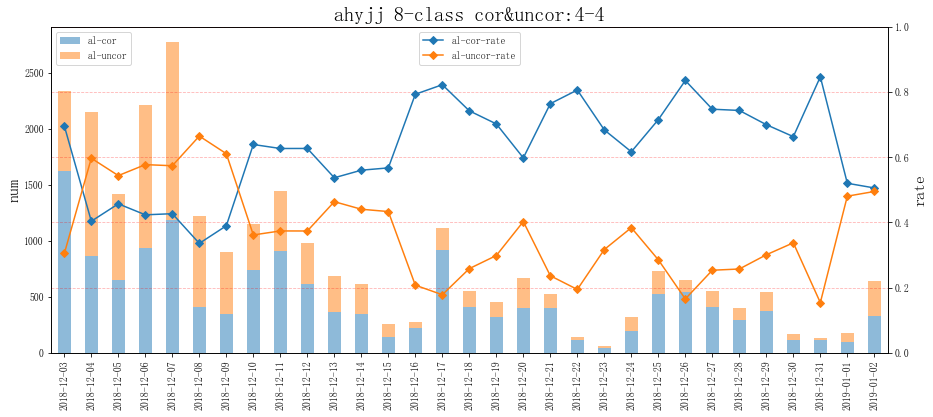

   publishtime  al_uncor     sum  al_cor  al_cor_rate  al_uncor_rate
30  2019-01-02   319.000 645.000 326.000        0.505          0.495
29  2019-01-01    85.000 177.000  92.000        0.520          0.480
28  2018-12-31    20.000 130.000 110.000        0.846          0.154
27  2018-12-30    58.000 172.000 114.000        0.663          0.337
26  2018-12-29   162.000 539.000 377.000        0.699          0.301


In [80]:
plot_cor(count_data_4, cbirc_day_thing, "ahyjj 8-class cor&uncor:4-4")

## 倾向性

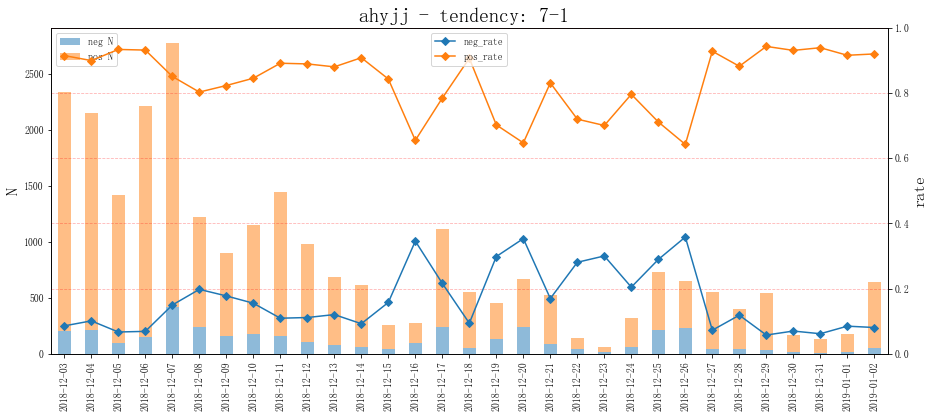

   publishtime  neg  pos  sum  neg_rate  pos_rate
30  2019-01-02   52  593  645     0.081     0.919
29  2019-01-01   15  162  177     0.085     0.915
28  2018-12-31    8  122  130     0.062     0.938
27  2018-12-30   12  160  172     0.070     0.930
26  2018-12-29   31  508  539     0.058     0.942


In [81]:
plot_tend(tend_count[tend_count['type'] == '安徽银监局'].drop('type', axis = 1), cbirc_day_thing, "ahyjj - tendency: 7-1 ")

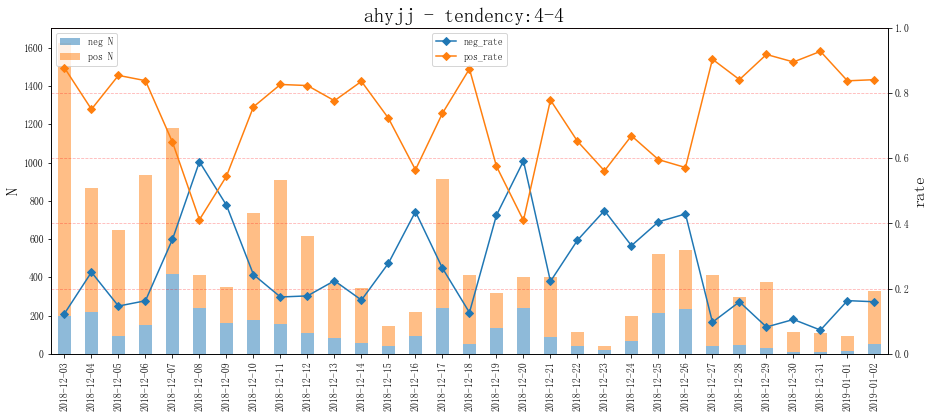

   publishtime  neg  pos  sum  neg_rate  pos_rate
30  2019-01-02   52  274  326     0.160     0.840
29  2019-01-01   15   77   92     0.163     0.837
28  2018-12-31    8  102  110     0.073     0.927
27  2018-12-30   12  102  114     0.105     0.895
26  2018-12-29   31  346  377     0.082     0.918


In [82]:
plot_tend(tend_count_4[tend_count_4['type'] == '安徽银监局'].drop('type', axis = 1), cbirc_day_thing, "ahyjj - tendency:4-4 ")

## 补录

In [ ]:
# plot_add(cbirc_add[cbirc_add['type'] == '安徽银监局'], cbirc_day_thing, "（安徽银监局）人工补录")

# 银保监会--新

## 特殊时间点

In [83]:
engine = specific_func.get_engine('cbirc')

In [84]:
cbirc_day_thing = [['2018-05-02', '相关性模型'], 
             ['2018-06-01', '更新相关性模型'], 
             ['2018-06-12', '更新相关性模型'], 
             ['2018-06-12', '上线倾向性模型']
            ]

In [85]:
start_day = today - datetime.timedelta(days=30) # 30 天
start_day = start_day.strftime("%Y-%m-%d") # '2018-08-12'  # 含
end_day = yesterday_str    # 含
print('start_day：',start_day)
print('end_day：',end_day)

# day_select = '2018-09-09'
day_list = get_day_list(start_day, end_day)
print(day_list)

start_day： 2018-12-04
end_day： 2019-01-02
['2018-12-05', '2018-12-06', '2018-12-07', '2018-12-08', '2018-12-09', '2018-12-10', '2018-12-11', '2018-12-12', '2018-12-13', '2018-12-14', '2018-12-15', '2018-12-16', '2018-12-17', '2018-12-18', '2018-12-19', '2018-12-20', '2018-12-21', '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25', '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29', '2018-12-30', '2018-12-31', '2019-01-01', '2019-01-02']


## 获取数据

In [86]:
for t in range(1, 6):
    print('获取 %s 的数据 -------'%(proj_name_dict[t]))
    for day in day_list:
        filename = 'result/statistics_result/mysql_daily_count_by_condition/%s_%s_mysql_stat.xlsx'%(proj_name_dict[t], day)
        if os.path.exists(filename):
            print('   已存在：', filename)
        else :
            t0 = time.time()
            sql_cbirc = '''
            SELECT
                t2.type,
                t1.traffic_id AS classify,
                t2.sen as tendency, 
                COUNT(t1.id) AS count,
                t2.gather_type,
                t3.group_id,
                t2.sec
            FROM
                cbrc_circ.db_classify_traffic_docinfo t1
                    LEFT JOIN
                cbrc_circ.db_docinfo_trade t2 ON t1.urlhash = t2.urlhash
                    LEFT JOIN
                cbrc_circ.db_docinfo t3 ON t2.urlhash = t3.urlhash
            WHERE
                t3.publishtime >= '{0} 00:00:00'
                AND t3.publishtime <= '{0} 23:59:59'
                    and t2.type = {1}
                    and t1.type = t2.type
            GROUP BY t2.gather_type, t2.type , t1.traffic_id, t3.group_id, t2.sen, t2.sec
            '''.format(day, t)

            cbirc_count_type = pd.read_sql(sql_cbirc, engine)     
            cbirc_count_type['publishtime'] = day
            cbirc_count_type.to_excel(filename, index = False)    
            print('   日期：%s ；耗时：%s s'%(day, time.time() - t0))
            print('   已生成：', filename)

获取 银监会 的数据 -------
   已存在： result/statistics_result/mysql_daily_count_by_condition/银监会_2018-12-05_mysql_stat.xlsx
   已存在： result/statistics_result/mysql_daily_count_by_condition/银监会_2018-12-06_mysql_stat.xlsx
   已存在： result/statistics_result/mysql_daily_count_by_condition/银监会_2018-12-07_mysql_stat.xlsx
   已存在： result/statistics_result/mysql_daily_count_by_condition/银监会_2018-12-08_mysql_stat.xlsx
   已存在： result/statistics_result/mysql_daily_count_by_condition/银监会_2018-12-09_mysql_stat.xlsx
   已存在： result/statistics_result/mysql_daily_count_by_condition/银监会_2018-12-10_mysql_stat.xlsx
   已存在： result/statistics_result/mysql_daily_count_by_condition/银监会_2018-12-11_mysql_stat.xlsx
   已存在： result/statistics_result/mysql_daily_count_by_condition/银监会_2018-12-12_mysql_stat.xlsx
   已存在： result/statistics_result/mysql_daily_count_by_condition/银监会_2018-12-13_mysql_stat.xlsx
   已存在： result/statistics_result/mysql_daily_count_by_condition/银监会_2018-12-14_mysql_stat.xlsx
   已存在： result/statistics_resul

   日期：2018-12-27 ；耗时：102.66487193107605 s
   已生成： result/statistics_result/mysql_daily_count_by_condition/中国人寿_2018-12-27_mysql_stat.xlsx
   日期：2018-12-28 ；耗时：77.61743950843811 s
   已生成： result/statistics_result/mysql_daily_count_by_condition/中国人寿_2018-12-28_mysql_stat.xlsx
   日期：2018-12-29 ；耗时：71.70210099220276 s
   已生成： result/statistics_result/mysql_daily_count_by_condition/中国人寿_2018-12-29_mysql_stat.xlsx
   日期：2018-12-30 ；耗时：47.45271396636963 s
   已生成： result/statistics_result/mysql_daily_count_by_condition/中国人寿_2018-12-30_mysql_stat.xlsx
   日期：2018-12-31 ；耗时：45.78261876106262 s
   已生成： result/statistics_result/mysql_daily_count_by_condition/中国人寿_2018-12-31_mysql_stat.xlsx
   日期：2019-01-01 ；耗时：35.56503415107727 s
   已生成： result/statistics_result/mysql_daily_count_by_condition/中国人寿_2019-01-01_mysql_stat.xlsx
   日期：2019-01-02 ；耗时：74.0122332572937 s
   已生成： result/statistics_result/mysql_daily_count_by_condition/中国人寿_2019-01-02_mysql_stat.xlsx
获取 建行北分 的数据 -------
   已存在： result/statis

In [87]:
cbirc_count_all = pd.DataFrame()
for t in range(1, 6):
    print('获取 %s 的数据 -------'%(proj_name_dict[t]))
    for day in day_list:
        filename = 'result/statistics_result/mysql_daily_count_by_condition/%s_%s_mysql_stat.xlsx'%(proj_name_dict[t], day)
        if os.path.exists(filename):
            cbirc_count_type = pd.read_excel(filename)
            cbirc_count_all = pd.concat([cbirc_count_all, cbirc_count_type], axis = 0)
        else :
            print('   不存在：', filename)

获取 银监会 的数据 -------
获取 保监会 的数据 -------
获取 中国人寿 的数据 -------
获取 建行北分 的数据 -------
获取 中国人保 的数据 -------


In [88]:
print(cbirc_count_all.shape)
cbirc_count_all.head()

(9401, 8)


,type,classify,tendency,count,gather_type,group_id,sec,publishtime
0,1,1,-1,99,0,1,4,2018-12-05
1,1,1,0,1420,0,1,4,2018-12-05
2,1,1,-1,1,0,2,4,2018-12-05
3,1,1,0,2,0,2,4,2018-12-05
4,1,1,-1,2,0,3,4,2018-12-05


### 八分类数据

In [89]:
cbirc_count = cbirc_count_all.groupby(['publishtime', 'type', 'classify'])['count'].sum()
cbirc_count = cbirc_count.reset_index(['publishtime', 'type', 'classify'])
cbirc_count.head()

,publishtime,type,classify,count
0,2018-12-05,1,1,2087
1,2018-12-05,1,2,3057
2,2018-12-05,1,3,1959
3,2018-12-05,1,4,6621
4,2018-12-05,1,5,2631


In [90]:
cbirc_count['classify'] = cbirc_count['classify'].apply(lambda x:class_name_dict[int(x)])
cbirc_count['type'] = cbirc_count['type'].apply(lambda x:proj_name_dict[int(x)])
print(cbirc_count.shape)
print(cbirc_count.info(memory_usage = 'deep'))
# cbirc_count.head()

print(cbirc_count['count'].sum())
cbirc_count.pivot_table(index = ['publishtime'], columns = ['type'], 
                        aggfunc = [np.sum], values = ['count'], 
                        fill_value = 0, margins = True)

(1214, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1214 entries, 0 to 1213
Data columns (total 4 columns):
publishtime    1214 non-null object
type           1214 non-null object
classify       1214 non-null object
count          1214 non-null int64
dtypes: int64(1), object(3)
memory usage: 314.5 KB
None
3520854


sum                                          
              count                                          
type           中国人保   中国人寿      保监会    建行北分      银监会      All
publishtime                                                  
2018-12-05    15651   5009    69653    1935    71467   163715
2018-12-06    14982   5255    69435    1650    74562   165884
2018-12-07    11796   3588    69972    2269    77952   165577
2018-12-08    13551   2113    42334    2489    45733   106220
2018-12-09    14927   1467    39247    1362    41982    98985
2018-12-10    23613   3067    52152    2523    67444   148799
2018-12-11    18922   3400    55011    1992    67409   146734
2018-12-12    13141   4664    57687    2032    73695   151219
2018-12-13    13861   5879    64195    2269    76649   162853
2018-12-14    15740   5233    63198    4782    70519   159472
2018-12-15    12144   1067    30775    2990    36086    83062
2018-12-16    15201    674    24445    1496    24706    66522
2018-12-17    15739   2677    57540    5673    57034   138663
2018-12-18    13408   3093    49150    3193    57036   125880
2018-12-19    11326   2845    40910    6911    43122   105114
2018-12-20    10481   4005    51211   13537    59536   138770
2018-12-21    10732   3052    50405   12106    57369   133664
2018-12-22     8647   1509    33938    4882    36865    85841
2018-12-23     8397    726    24840    3723    21017    58703
2018-12-24    12556   3661    54001    7967    57920   136105
2018-12-25     9817   2415    49821    7569    54508   124130
2018-12-26    12093   1914    45410    6308    57932   123657
2018-12-27     9291   2856    42602   10713    88111   153573
2018-12-28     4396   2117    30420    8530    94109   139572
2018-12-29     4793   1265    28070    7678    89412   131218
2018-12-30     4348    311    20200    2731    40587    68177
2018-12-31     4064   1003    17224    1142    38601    62034
2019-01-01     2702    351    10242     676    44902    58873
2019-01-02     7991   1822    32757    1664    73604   117838
All          334310  77038  1276845  132792  1699869  3520854

### 倾向性数据

In [91]:
tend_count = cbirc_count_all.groupby(['publishtime', 'type', 'tendency'])['count'].sum()
tend_count = tend_count.reset_index(['publishtime', 'type', 'tendency'])
tend_count.head()

,publishtime,type,tendency,count
0,2018-12-05,1,-1,2383
1,2018-12-05,1,0,69084
2,2018-12-05,2,-1,1682
3,2018-12-05,2,0,67971
4,2018-12-05,3,-1,230


In [92]:
# cor_list = ['产品销售', '资本市场', '其他相关报道', '噪音'] # 3、4、7、8
cor_list = [3,4,7,8]
tend_count_4 = cbirc_count_all[~cbirc_count_all['classify'].isin(cor_list)].groupby(['publishtime', 'type', 'tendency'])['count'].sum()
tend_count_4 = tend_count_4.reset_index(['publishtime', 'type', 'tendency'])
tend_count_4['type'] = tend_count_4['type'].apply(lambda x:proj_name_dict[int(x)])
tend_count_4.head()

,publishtime,type,tendency,count
0,2018-12-05,银监会,-1,2383
1,2018-12-05,银监会,0,7224
2,2018-12-05,保监会,-1,1682
3,2018-12-05,保监会,0,6338
4,2018-12-05,中国人寿,-1,225


In [93]:
tend_count['type'] = tend_count['type'].apply(lambda x:proj_name_dict[int(x)])
print(tend_count.shape)
print(tend_count.info(memory_usage = 'deep'))
# tend_count.head()

print(tend_count['count'].sum())
tend_count.pivot_table(index = ['publishtime'], columns = ['type'], 
                        aggfunc = [np.sum], values = ['count'], 
                        fill_value = 0, margins = True)

(292, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 4 columns):
publishtime    292 non-null object
type           292 non-null object
tendency       292 non-null int64
count          292 non-null int64
dtypes: int64(2), object(2)
memory usage: 52.5 KB
None
3520854


sum                                          
              count                                          
type           中国人保   中国人寿      保监会    建行北分      银监会      All
publishtime                                                  
2018-12-05    15651   5009    69653    1935    71467   163715
2018-12-06    14982   5255    69435    1650    74562   165884
2018-12-07    11796   3588    69972    2269    77952   165577
2018-12-08    13551   2113    42334    2489    45733   106220
2018-12-09    14927   1467    39247    1362    41982    98985
2018-12-10    23613   3067    52152    2523    67444   148799
2018-12-11    18922   3400    55011    1992    67409   146734
2018-12-12    13141   4664    57687    2032    73695   151219
2018-12-13    13861   5879    64195    2269    76649   162853
2018-12-14    15740   5233    63198    4782    70519   159472
2018-12-15    12144   1067    30775    2990    36086    83062
2018-12-16    15201    674    24445    1496    24706    66522
2018-12-17    15739   2677    57540    5673    57034   138663
2018-12-18    13408   3093    49150    3193    57036   125880
2018-12-19    11326   2845    40910    6911    43122   105114
2018-12-20    10481   4005    51211   13537    59536   138770
2018-12-21    10732   3052    50405   12106    57369   133664
2018-12-22     8647   1509    33938    4882    36865    85841
2018-12-23     8397    726    24840    3723    21017    58703
2018-12-24    12556   3661    54001    7967    57920   136105
2018-12-25     9817   2415    49821    7569    54508   124130
2018-12-26    12093   1914    45410    6308    57932   123657
2018-12-27     9291   2856    42602   10713    88111   153573
2018-12-28     4396   2117    30420    8530    94109   139572
2018-12-29     4793   1265    28070    7678    89412   131218
2018-12-30     4348    311    20200    2731    40587    68177
2018-12-31     4064   1003    17224    1142    38601    62034
2019-01-01     2702    351    10242     676    44902    58873
2019-01-02     7991   1822    32757    1664    73604   117838
All          334310  77038  1276845  132792  1699869  3520854

### 补录数据

In [94]:
cbirc_add = cbirc_count_all.groupby(['publishtime', 'type', 'gather_type'])['count'].sum()
cbirc_add = cbirc_add.reset_index(['publishtime', 'type', 'gather_type'])
cbirc_add = cbirc_add[cbirc_add['gather_type'].isin([1,3])]
cbirc_add.head()

,publishtime,type,gather_type,count
3,2018-12-05,3,1,11
6,2018-12-05,4,1,9
8,2018-12-05,5,1,6
13,2018-12-06,3,1,4
16,2018-12-06,4,1,8


In [95]:
# cbirc_add['gather_type'] = cbirc_add['gather_type'].apply(lambda x:group_dict[str(x)])
cbirc_add['type'] = cbirc_add['type'].apply(lambda x:proj_name_dict[int(x)])
print(cbirc_add.shape)
print(cbirc_add.info(memory_usage = 'deep'))
# cbirc_count.head()

print(cbirc_add['count'].sum())
cbirc_add.pivot_table(index = ['publishtime'], columns = ['type', 'gather_type'], 
                        aggfunc = [np.sum], values = ['count'], 
                        fill_value = 0, margins = True)

(62, 4)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 62 entries, 3 to 247
Data columns (total 4 columns):
publishtime    62 non-null object
type           62 non-null object
gather_type    62 non-null int64
count          62 non-null int64
dtypes: int64(2), object(2)
memory usage: 11.7 KB
None
258


sum                       
            count                       
type         中国人保 中国人寿 保监会 建行北分 银监会  All
gather_type     1    1   1    1   1     
publishtime                             
2018-12-05      6   11   0    9   0   26
2018-12-06      1    4   0    8   0   13
2018-12-07      2    4   0    7   0   13
2018-12-08      0    0   0    2   0    2
2018-12-09      1    0   0    1   0    2
2018-12-10      6    3   0    3   0   12
2018-12-11      2   10   0    2   0   14
2018-12-12      6    8   0    4   0   18
2018-12-13      3    8   0    5   0   16
2018-12-14      1    8   0    7   0   16
2018-12-15      0    0   0    2   0    2
2018-12-16      1    0   0    1   0    2
2018-12-17      4    0   0    1   0    5
2018-12-18      4    0   0    4   0    8
2018-12-19      2    0   0    2   0    4
2018-12-20      2    0   0    1   0    3
2018-12-21      2    0   0    1   0    3
2018-12-22      0    0   0    5   0    5
2018-12-23      1    0   0    1   0    2
2018-12-24      6    0   0    0   0    6
2018-12-25      6    0   0    0   0    6
2018-12-26      3    0   0    0   0    3
2018-12-27      4    0   0    8   0   12
2018-12-28      4    0   0   19   1   24
2018-12-29      5    0   0   16   0   21
2018-12-30      0    0   0    1   0    1
2018-12-31      1    0   0    1   0    2
2019-01-01      0    0   0    2   0    2
2019-01-02      8    1   1    3   2   15
All            81   57   1  116   3  258

## 八分类
- 20191219
  - 银监会：
  - 保监会：
  - 中国人寿：
  - 建行北分：
  - 中国人保：
- 20191219
  - 银监会：
  - 保监会：
  - 中国人寿：
  - 建行北分：
  - 中国人保：

### 银监会

In [96]:
class_count = cbirc_count[cbirc_count['type'] == '银监会'].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                  总量    非噪音  \
classify     产品销售 公司内部管理 其他相关报道     噪音  消费服务    监管    行业  资本市场                 
publishtime                                                                    
2019-01-02   1180   3393   2956  44702  4760  4759  4013  7841  73604  28902   
2019-01-01    997   1588   8213  22524  1293  3053  1885  5349  44902  22378   
2018-12-31    596    802   1711  24685  1321  3585  1478  4423  38601  13916   
2018-12-30    754   1776   1749  26869  1804  2955  1330  3350  40587  13718   
2018-12-29   2161   5301   3925  54967  3447  6160  5175  8276  89412  34445   

            非噪音-比例 噪音-比例  
classify                  
publishtime               
2019-01-02   0.393 0.607  
2019-01-01   0.498 0.502  
2018-12-31   0.361 0.639  
2018-12-30   0.338 0.662  
2018-12-29   0.385 0.615

count                                                  总量  rate  \
classify     产品销售 公司内部管理 其他相关报道     噪音  消费服务    监管    行业  资本市场         产品销售   
publishtime                                                                   
2019-01-02   1180   3393   2956  44702  4760  4759  4013  7841  73604 0.016   
2019-01-01    997   1588   8213  22524  1293  3053  1885  5349  44902 0.022   
2018-12-31    596    802   1711  24685  1321  3585  1478  4423  38601 0.015   
2018-12-30    754   1776   1749  26869  1804  2955  1330  3350  40587 0.019   
2018-12-29   2161   5301   3925  54967  3447  6160  5175  8276  89412 0.024   

                                                         
classify    公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场  
publishtime                                              
2019-01-02   0.046  0.040 0.607 0.065 0.065 0.055 0.107  
2019-01-01   0.035  0.183 0.502 0.029 0.068 0.042 0.119  
2018-12-31   0.021  0.044 0.639 0.034 0.093 0.038 0.115  
2018-12-30   0.044  0.043 0.662 0.044 0.073 0.033 0.083  
2018-12-29   0.059  0.044 0.615 0.039 0.069 0.058 0.093

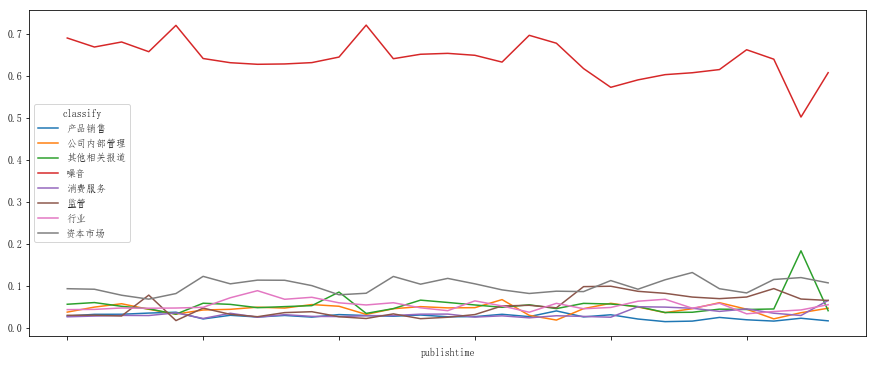

In [97]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

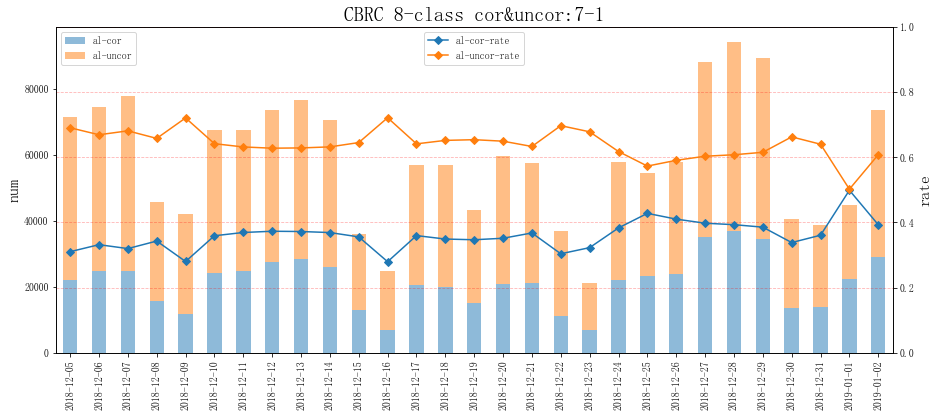

   publishtime    sum  al_cor  al_uncor  al_cor_rate  al_uncor_rate
28  2019-01-02  73604   28902     44702        0.393          0.607
27  2019-01-01  44902   22378     22524        0.498          0.502
26  2018-12-31  38601   13916     24685        0.361          0.639
25  2018-12-30  40587   13718     26869        0.338          0.662
24  2018-12-29  89412   34445     54967        0.385          0.615


In [98]:
plot_cor(count_data_7, cbirc_day_thing, "CBRC 8-class cor&uncor:7-1")

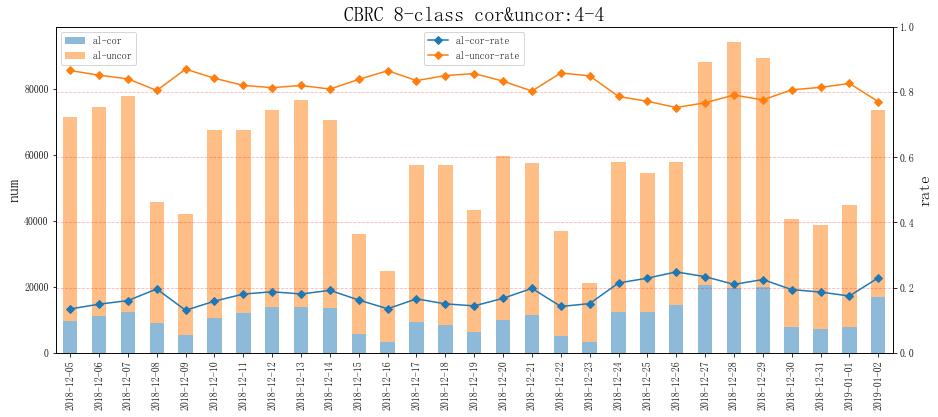

   publishtime  al_uncor    sum  al_cor  al_cor_rate  al_uncor_rate
28  2019-01-02     56679  73604   16925        0.230          0.770
27  2019-01-01     37083  44902    7819        0.174          0.826
26  2018-12-31     31415  38601    7186        0.186          0.814
25  2018-12-30     32722  40587    7865        0.194          0.806
24  2018-12-29     69329  89412   20083        0.225          0.775


In [99]:
plot_cor(count_data_4, cbirc_day_thing, "CBRC 8-class cor&uncor:4-4")

### 保监会

In [100]:
class_count = cbirc_count[cbirc_count['type'] == '保监会'].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                总量   非噪音  \
classify     产品销售 公司内部管理 其他相关报道     噪音 消费服务    监管   行业  资本市场                
publishtime                                                                 
2019-01-02    431    576    402  26196  841   778  918  2615  32757  6561   
2019-01-01     64     77     71   8555  236   197  389   653  10242  1687   
2018-12-31    122    251    388  13665  503  1111  427   757  17224  3559   
2018-12-30    111    153    150  17508  570   436  593   679  20200  2692   
2018-12-29    282    656    623  23048  985   967  715   794  28070  5022   

            非噪音-比例 噪音-比例  
classify                  
publishtime               
2019-01-02   0.200 0.800  
2019-01-01   0.165 0.835  
2018-12-31   0.207 0.793  
2018-12-30   0.133 0.867  
2018-12-29   0.179 0.821

count                                                总量  rate  \
classify     产品销售 公司内部管理 其他相关报道     噪音 消费服务    监管   行业  资本市场         产品销售   
publishtime                                                                 
2019-01-02    431    576    402  26196  841   778  918  2615  32757 0.013   
2019-01-01     64     77     71   8555  236   197  389   653  10242 0.006   
2018-12-31    122    251    388  13665  503  1111  427   757  17224 0.007   
2018-12-30    111    153    150  17508  570   436  593   679  20200 0.005   
2018-12-29    282    656    623  23048  985   967  715   794  28070 0.010   

                                                         
classify    公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场  
publishtime                                              
2019-01-02   0.018  0.012 0.800 0.026 0.024 0.028 0.080  
2019-01-01   0.008  0.007 0.835 0.023 0.019 0.038 0.064  
2018-12-31   0.015  0.023 0.793 0.029 0.065 0.025 0.044  
2018-12-30   0.008  0.007 0.867 0.028 0.022 0.029 0.034  
2018-12-29   0.023  0.022 0.821 0.035 0.034 0.025 0.028

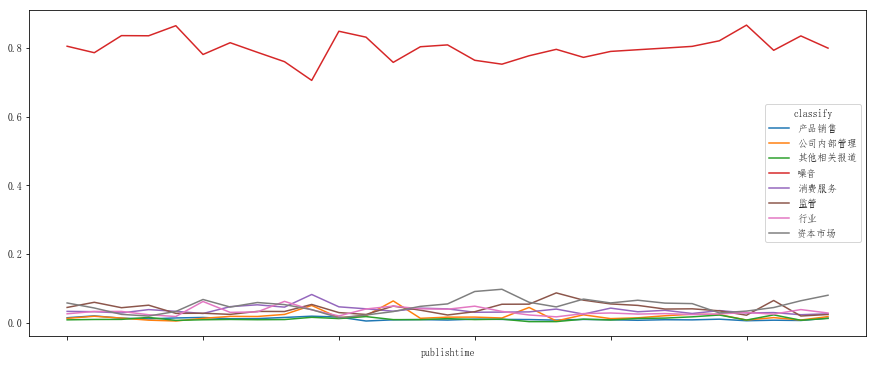

In [101]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

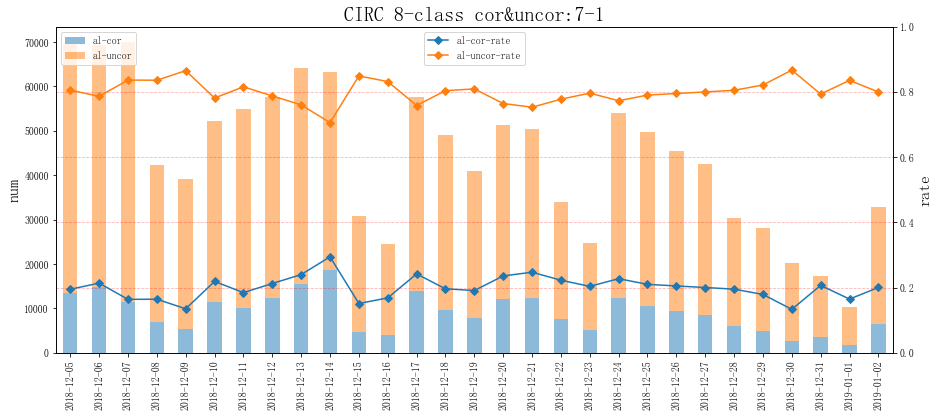

   publishtime    sum  al_cor  al_uncor  al_cor_rate  al_uncor_rate
28  2019-01-02  32757    6561     26196        0.200          0.800
27  2019-01-01  10242    1687      8555        0.165          0.835
26  2018-12-31  17224    3559     13665        0.207          0.793
25  2018-12-30  20200    2692     17508        0.133          0.867
24  2018-12-29  28070    5022     23048        0.179          0.821


In [102]:
plot_cor(count_data_7, cbirc_day_thing, "CIRC 8-class cor&uncor:7-1")

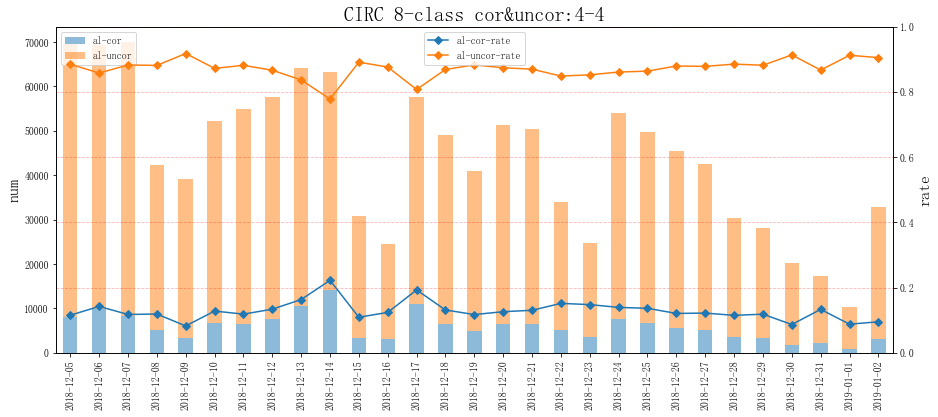

   publishtime  al_uncor    sum  al_cor  al_cor_rate  al_uncor_rate
28  2019-01-02     29644  32757    3113        0.095          0.905
27  2019-01-01      9343  10242     899        0.088          0.912
26  2018-12-31     14932  17224    2292        0.133          0.867
25  2018-12-30     18448  20200    1752        0.087          0.913
24  2018-12-29     24747  28070    3323        0.118          0.882


In [103]:
plot_cor(count_data_4, cbirc_day_thing, "CIRC 8-class cor&uncor:4-4")

### 中国人寿

In [104]:
class_count = cbirc_count[cbirc_count['type'] == '中国人寿'].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                        \
classify      产品销售  公司内部管理 其他相关报道       噪音   消费服务     监管      行业    资本市场   
publishtime                                                                
2019-01-02  18.000 114.000 13.000 1384.000 16.000 13.000 124.000 140.000   
2019-01-01     nan   6.000    nan  300.000 14.000    nan  13.000  18.000   
2018-12-31   1.000  23.000  8.000  688.000 10.000 95.000 138.000  40.000   
2018-12-30   1.000   8.000  1.000  246.000  7.000  4.000  41.000   3.000   
2018-12-29   6.000  63.000 15.000 1019.000 21.000  8.000  99.000  34.000   

                  总量     非噪音 非噪音-比例 噪音-比例  
classify                                   
publishtime                                
2019-01-02  1822.000 438.000  0.240 0.760  
2019-01-01   351.000  51.000  0.145 0.855  
2018-12-31  1003.000 315.000  0.314 0.686  
2018-12-30   311.000  65.000  0.209 0.791  
2018-12-29  1265.000 246.000  0.194 0.806

count                                                        \
classify      产品销售  公司内部管理 其他相关报道       噪音   消费服务     监管      行业    资本市场   
publishtime                                                                
2019-01-02  18.000 114.000 13.000 1384.000 16.000 13.000 124.000 140.000   
2019-01-01     nan   6.000    nan  300.000 14.000    nan  13.000  18.000   
2018-12-31   1.000  23.000  8.000  688.000 10.000 95.000 138.000  40.000   
2018-12-30   1.000   8.000  1.000  246.000  7.000  4.000  41.000   3.000   
2018-12-29   6.000  63.000 15.000 1019.000 21.000  8.000  99.000  34.000   

                  总量  rate                                              
classify              产品销售 公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场  
publishtime                                                             
2019-01-02  1822.000 0.010  0.063  0.007 0.760 0.009 0.007 0.068 0.077  
2019-01-01   351.000   nan  0.017    nan 0.855 0.040   nan 0.037 0.051  
2018-12-31  1003.000 0.001  0.023  0.008 0.686 0.010 0.095 0.138 0.040  
2018-12-30   311.000 0.003  0.026  0.003 0.791 0.023 0.013 0.132 0.010  
2018-12-29  1265.000 0.005  0.050  0.012 0.806 0.017 0.006 0.078 0.027

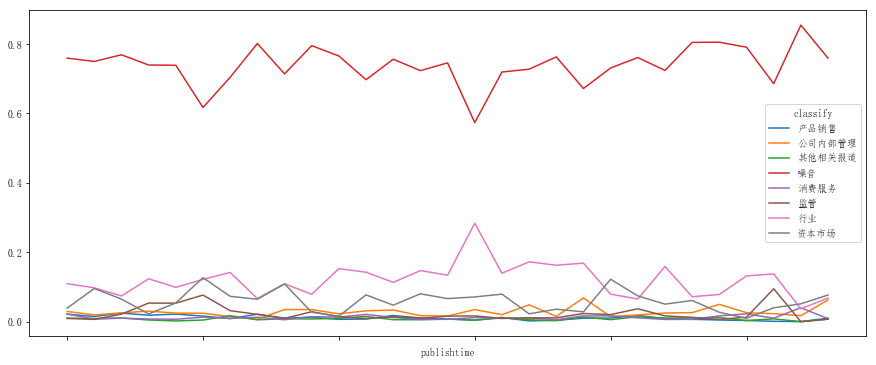

In [105]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

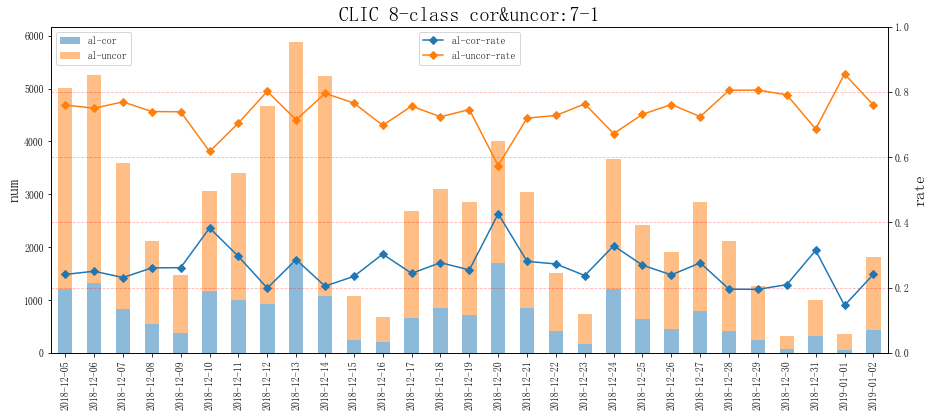

   publishtime      sum  al_cor  al_uncor  al_cor_rate  al_uncor_rate
28  2019-01-02 1822.000 438.000  1384.000        0.240          0.760
27  2019-01-01  351.000  51.000   300.000        0.145          0.855
26  2018-12-31 1003.000 315.000   688.000        0.314          0.686
25  2018-12-30  311.000  65.000   246.000        0.209          0.791
24  2018-12-29 1265.000 246.000  1019.000        0.194          0.806


In [106]:
plot_cor(count_data_7, cbirc_day_thing, "CLIC 8-class cor&uncor:7-1")

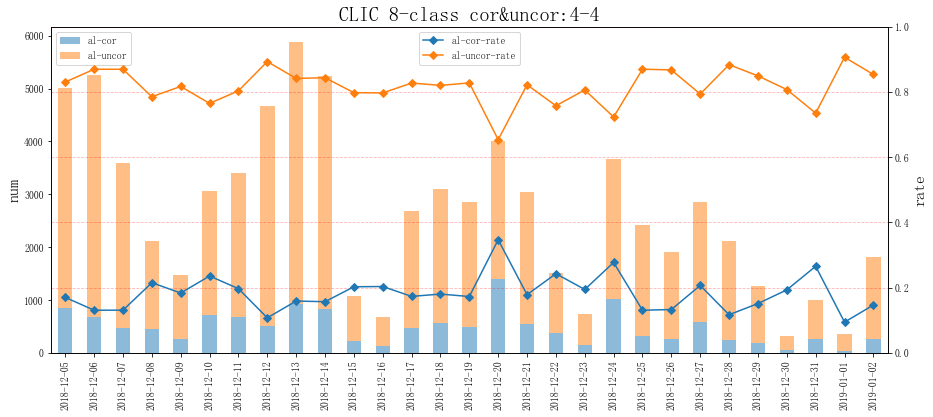

   publishtime  al_uncor      sum  al_cor  al_cor_rate  al_uncor_rate
28  2019-01-02  1555.000 1822.000 267.000        0.147          0.853
27  2019-01-01   318.000  351.000  33.000        0.094          0.906
26  2018-12-31   737.000 1003.000 266.000        0.265          0.735
25  2018-12-30   251.000  311.000  60.000        0.193          0.807
24  2018-12-29  1074.000 1265.000 191.000        0.151          0.849


In [107]:
plot_cor(count_data_4, cbirc_day_thing, "CLIC 8-class cor&uncor:4-4")

### 建行北分

In [108]:
class_count = cbirc_count[cbirc_count['type'] == '建行北分'].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                            总量   非噪音 非噪音-比例  \
classify     产品销售 公司内部管理 其他相关报道    噪音 消费服务   监管   行业 资本市场                      
publishtime                                                                    
2019-01-02      1     48     56   694    9  426  299  131  1664   970  0.583   
2019-01-01      1     35     25   261   11  167   94   82   676   415  0.614   
2018-12-31     11     13     12   259   47  661   81   58  1142   883  0.773   
2018-12-30     79    102    187  1646  109  278  155  175  2731  1085  0.397   
2018-12-29    155    443    478  4371  197  838  525  671  7678  3307  0.431   

            噪音-比例  
classify           
publishtime        
2019-01-02  0.417  
2019-01-01  0.386  
2018-12-31  0.227  
2018-12-30  0.603  
2018-12-29  0.569

count                                            总量  rate         \
classify     产品销售 公司内部管理 其他相关报道    噪音 消费服务   监管   行业 资本市场        产品销售 公司内部管理   
publishtime                                                                    
2019-01-02      1     48     56   694    9  426  299  131  1664 0.001  0.029   
2019-01-01      1     35     25   261   11  167   94   82   676 0.001  0.052   
2018-12-31     11     13     12   259   47  661   81   58  1142 0.010  0.011   
2018-12-30     79    102    187  1646  109  278  155  175  2731 0.029  0.037   
2018-12-29    155    443    478  4371  197  838  525  671  7678 0.020  0.058   

                                                  
classify    其他相关报道    噪音  消费服务    监管    行业  资本市场  
publishtime                                       
2019-01-02   0.034 0.417 0.005 0.256 0.180 0.079  
2019-01-01   0.037 0.386 0.016 0.247 0.139 0.121  
2018-12-31   0.011 0.227 0.041 0.579 0.071 0.051  
2018-12-30   0.068 0.603 0.040 0.102 0.057 0.064  
2018-12-29   0.062 0.569 0.026 0.109 0.068 0.087

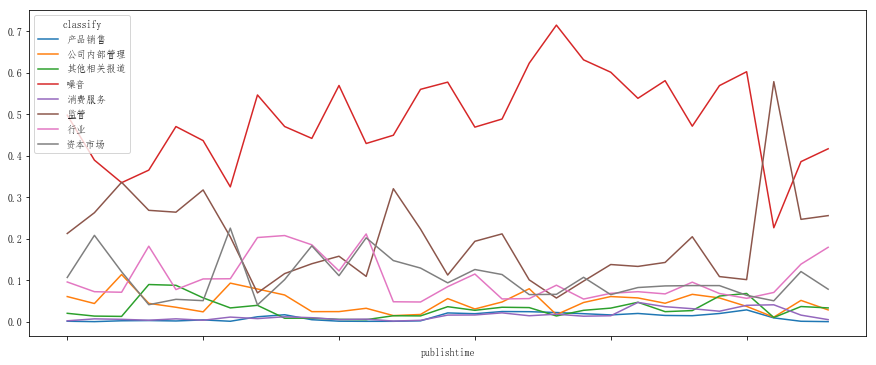

In [109]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

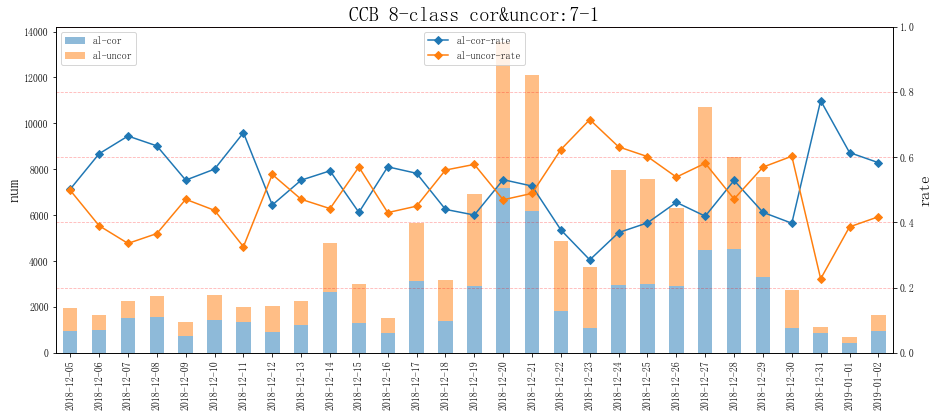

   publishtime   sum  al_cor  al_uncor  al_cor_rate  al_uncor_rate
28  2019-01-02  1664     970       694        0.583          0.417
27  2019-01-01   676     415       261        0.614          0.386
26  2018-12-31  1142     883       259        0.773          0.227
25  2018-12-30  2731    1085      1646        0.397          0.603
24  2018-12-29  7678    3307      4371        0.431          0.569


In [110]:
plot_cor(count_data_7, cbirc_day_thing, "CCB 8-class cor&uncor:7-1")

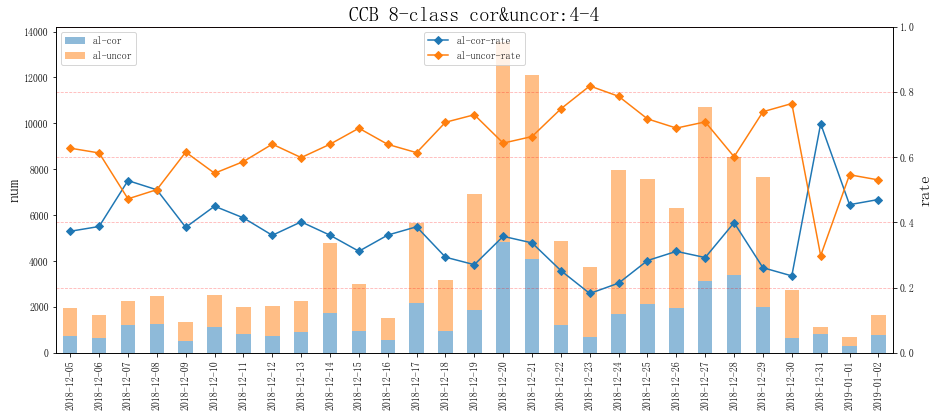

   publishtime  al_uncor   sum  al_cor  al_cor_rate  al_uncor_rate
28  2019-01-02       882  1664     782        0.470          0.530
27  2019-01-01       369   676     307        0.454          0.546
26  2018-12-31       340  1142     802        0.702          0.298
25  2018-12-30      2087  2731     644        0.236          0.764
24  2018-12-29      5675  7678    2003        0.261          0.739


In [111]:
plot_cor(count_data_4, cbirc_day_thing, "CCB 8-class cor&uncor:4-4")

### 中国人保

In [112]:
class_count = cbirc_count[cbirc_count['type'] == '中国人保'].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                       \
classify          交通   产品销售 公司内部管理  其他相关报道       噪音   消费服务      环保     监管   
publishtime                                                                 
2019-01-02  1089.000 19.000 66.000  27.000 6252.000 55.000  97.000  6.000   
2019-01-01   436.000  3.000 10.000   5.000 2112.000 18.000  75.000    nan   
2018-12-31   370.000  4.000 23.000   4.000 3381.000 16.000 166.000 41.000   
2018-12-30   289.000  5.000 12.000  11.000 3716.000 18.000 214.000  5.000   
2018-12-29   269.000  9.000 36.000 127.000 4034.000 45.000 195.000 15.000   

                                 总量      非噪音 非噪音-比例 噪音-比例  
classify         行业   资本市场                                 
publishtime                                                
2019-01-02  310.000 70.000 7991.000 1739.000  0.218 0.782  
2019-01-01   34.000  9.000 2702.000  590.000  0.218 0.782  
2018-12-31   55.000  4.000 4064.000  683.000  0.168 0.832  
2018-12-30   71.000  7.000 4348.000  632.000  0.145 0.855  
2018-12-29   55.000  8.000 4793.000  759.000  0.158 0.842

count                                                       \
classify          交通   产品销售 公司内部管理  其他相关报道       噪音   消费服务      环保     监管   
publishtime                                                                 
2019-01-02  1089.000 19.000 66.000  27.000 6252.000 55.000  97.000  6.000   
2019-01-01   436.000  3.000 10.000   5.000 2112.000 18.000  75.000    nan   
2018-12-31   370.000  4.000 23.000   4.000 3381.000 16.000 166.000 41.000   
2018-12-30   289.000  5.000 12.000  11.000 3716.000 18.000 214.000  5.000   
2018-12-29   269.000  9.000 36.000 127.000 4034.000 45.000 195.000 15.000   

                            ...   rate                                        \
classify         行业   资本市场  ...     交通  产品销售 公司内部管理 其他相关报道    噪音  消费服务    环保   
publishtime                 ...                                                
2019-01-02  310.000 70.000  ...  0.136 0.002  0.008  0.003 0.782 0.007 0.012   
2019-01-01   34.000  9.000  ...  0.161 0.001  0.004  0.002 0.782 0.007 0.028   
2018-12-31   55.000  4.000  ...  0.091 0.001  0.006  0.001 0.832 0.004 0.041   
2018-12-30   71.000  7.000  ...  0.066 0.001  0.003  0.003 0.855 0.004 0.049   
2018-12-29   55.000  8.000  ...  0.056 0.002  0.008  0.026 0.842 0.009 0.041   

                               
classify       监管    行业  资本市场  
publishtime                    
2019-01-02  0.001 0.039 0.009  
2019-01-01    nan 0.013 0.003  
2018-12-31  0.010 0.014 0.001  
2018-12-30  0.001 0.016 0.002  
2018-12-29  0.003 0.011 0.002  

[5 rows x 21 columns]

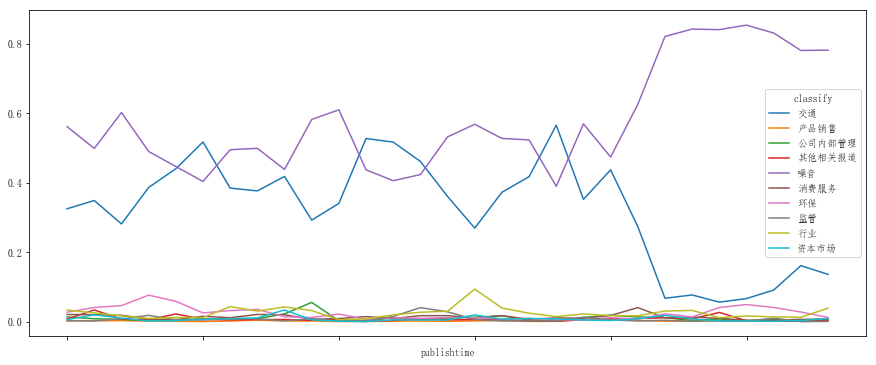

In [113]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

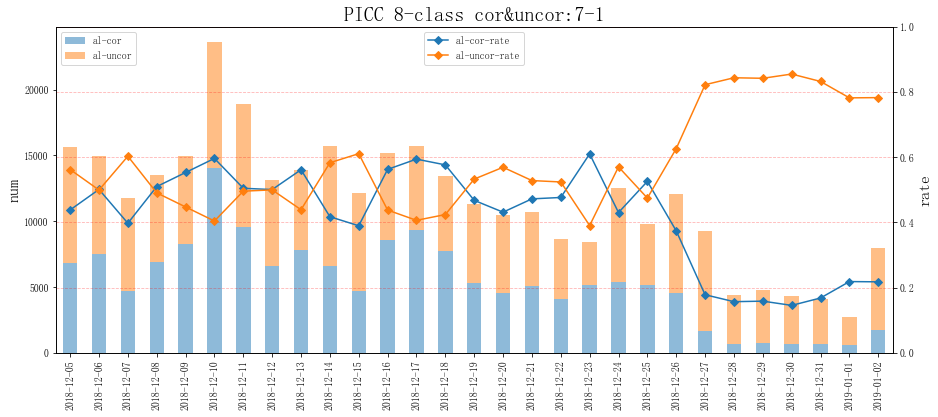

   publishtime      sum   al_cor  al_uncor  al_cor_rate  al_uncor_rate
28  2019-01-02 7991.000 1739.000  6252.000        0.218          0.782
27  2019-01-01 2702.000  590.000  2112.000        0.218          0.782
26  2018-12-31 4064.000  683.000  3381.000        0.168          0.832
25  2018-12-30 4348.000  632.000  3716.000        0.145          0.855
24  2018-12-29 4793.000  759.000  4034.000        0.158          0.842


In [114]:
plot_cor(count_data_7, cbirc_day_thing, "PICC 8-class cor&uncor:7-1")

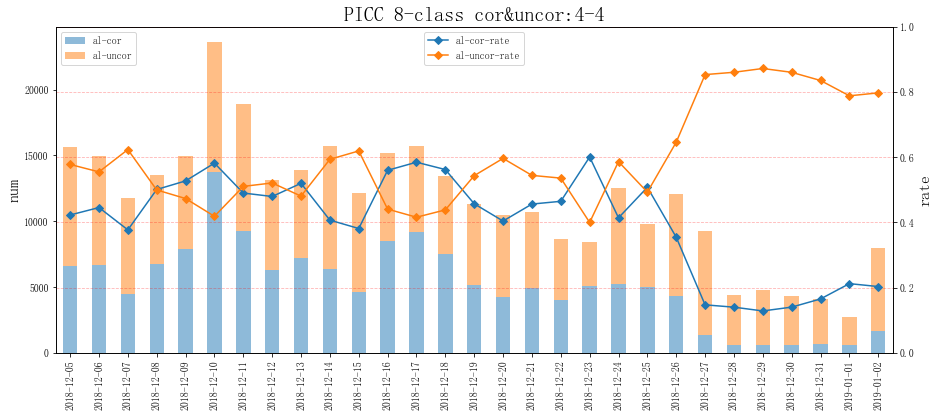

   publishtime  al_uncor      sum   al_cor  al_cor_rate  al_uncor_rate
28  2019-01-02  6368.000 7991.000 1623.000        0.203          0.797
27  2019-01-01  2129.000 2702.000  573.000        0.212          0.788
26  2018-12-31  3393.000 4064.000  671.000        0.165          0.835
25  2018-12-30  3739.000 4348.000  609.000        0.140          0.860
24  2018-12-29  4178.000 4793.000  615.000        0.128          0.872


In [115]:
plot_cor(count_data_4, cbirc_day_thing, "PICC 8-class cor&uncor:4-4")

## 倾向性
- 20191219
  - 银监会：
  - 保监会：
  - 中国人寿：
  - 建行北分：
  - 中国人保：
- 20191219
  - 银监会：
  - 保监会：
  - 中国人寿：
  - 建行北分：
  - 中国人保：

### 银监会

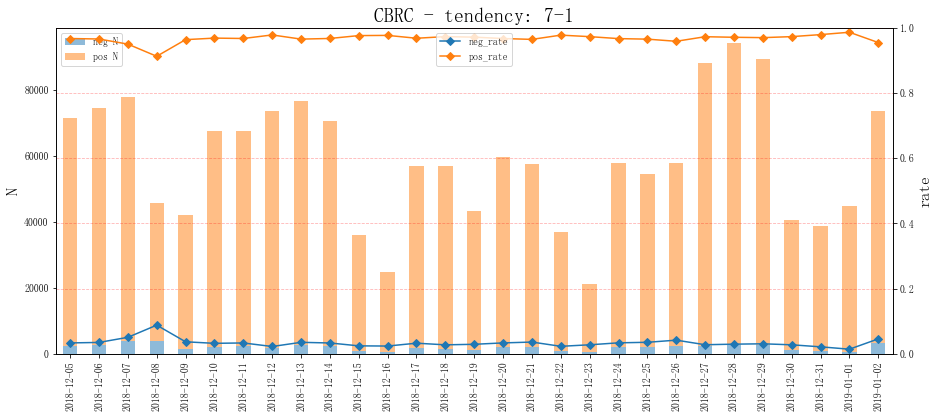

   publishtime   neg    pos    sum  neg_rate  pos_rate
28  2019-01-02  3363  70241  73604     0.046     0.954
27  2019-01-01   635  44267  44902     0.014     0.986
26  2018-12-31   825  37776  38601     0.021     0.979
25  2018-12-30  1119  39468  40587     0.028     0.972
24  2018-12-29  2741  86671  89412     0.031     0.969


In [116]:
plot_tend(tend_count[tend_count['type'] == '银监会'].drop('type', axis = 1), cbirc_day_thing, "CBRC - tendency: 7-1")

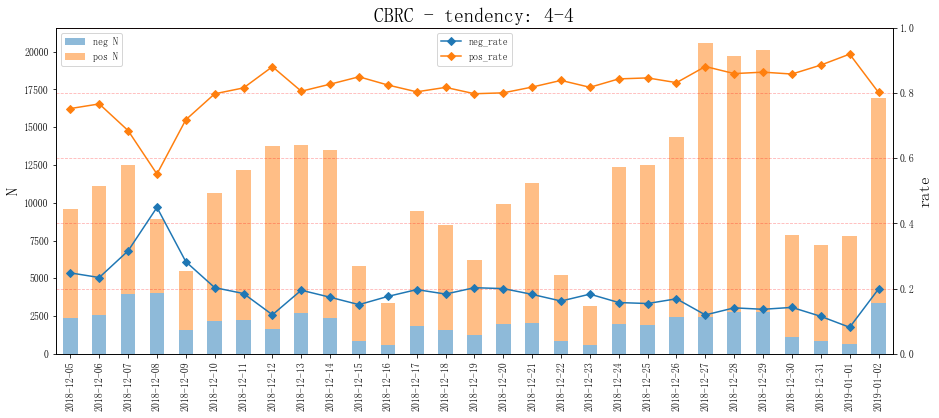

   publishtime   neg    pos    sum  neg_rate  pos_rate
28  2019-01-02  3363  13562  16925     0.199     0.801
27  2019-01-01   635   7184   7819     0.081     0.919
26  2018-12-31   825   6361   7186     0.115     0.885
25  2018-12-30  1119   6746   7865     0.142     0.858
24  2018-12-29  2741  17342  20083     0.136     0.864


In [117]:
plot_tend(tend_count_4[tend_count_4['type'] == '银监会'].drop('type', axis = 1), cbirc_day_thing, "CBRC - tendency: 4-4")

### 保监会

In [118]:
plot_tend(tend_count[tend_count['type'] == '保监会'].drop('type', axis = 1), cbirc_day_thing, "CIRC - tendency: 7-1")

ValueError: Length mismatch: Expected axis has 3 elements, new values have 2 elements

In [119]:
plot_tend(tend_count_4[tend_count_4['type'] == '保监会'].drop('type', axis = 1), cbirc_day_thing, "CIRC - tendency: 4-4")

ValueError: Length mismatch: Expected axis has 3 elements, new values have 2 elements

### 中国人寿

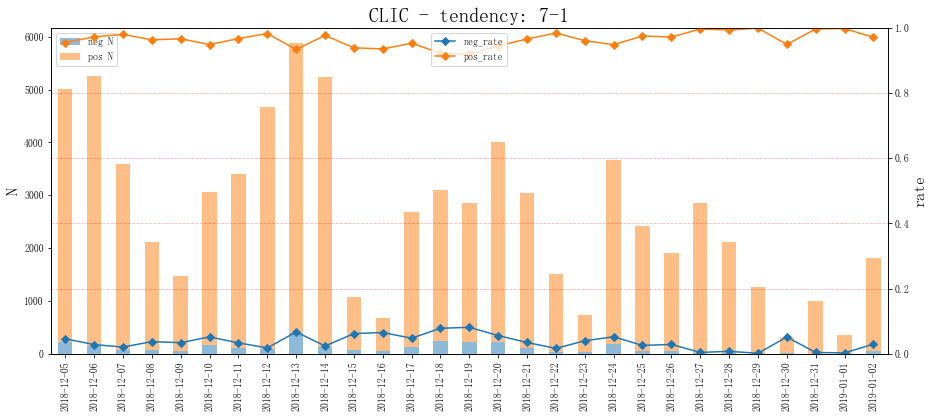

   publishtime  neg   pos   sum  neg_rate  pos_rate
28  2019-01-02   54  1768  1822     0.030     0.970
27  2019-01-01    1   350   351     0.003     0.997
26  2018-12-31    4   999  1003     0.004     0.996
25  2018-12-30   16   295   311     0.051     0.949
24  2018-12-29    2  1263  1265     0.002     0.998


In [120]:
plot_tend(tend_count[tend_count['type'] == '中国人寿'].drop('type', axis = 1), cbirc_day_thing, "CLIC - tendency: 7-1")

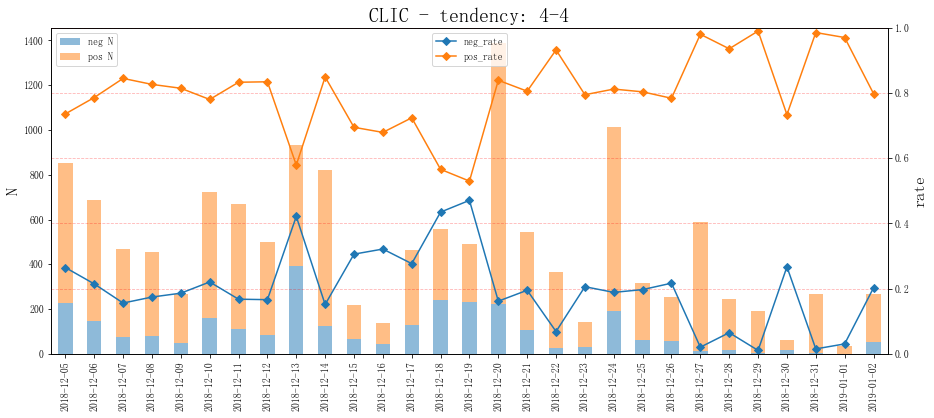

   publishtime  neg  pos  sum  neg_rate  pos_rate
28  2019-01-02   54  213  267     0.202     0.798
27  2019-01-01    1   32   33     0.030     0.970
26  2018-12-31    4  262  266     0.015     0.985
25  2018-12-30   16   44   60     0.267     0.733
24  2018-12-29    2  189  191     0.010     0.990


In [121]:
plot_tend(tend_count_4[tend_count_4['type'] == '中国人寿'].drop('type', axis = 1), cbirc_day_thing, "CLIC - tendency: 4-4")

### 建行北分

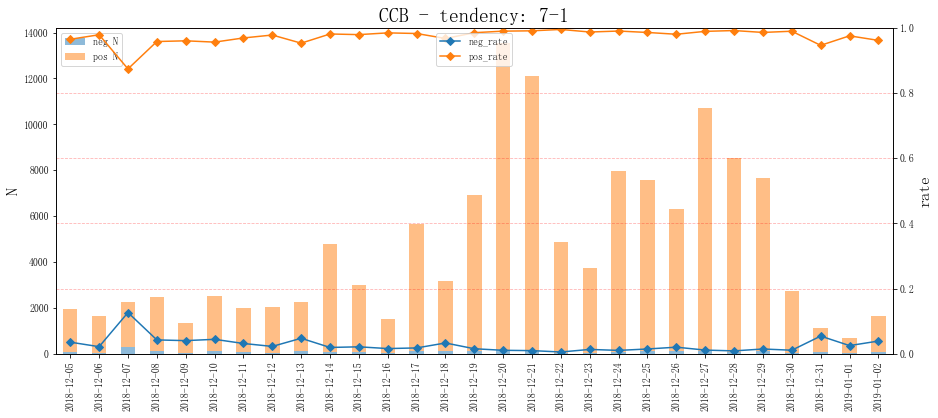

   publishtime  neg   pos   sum  neg_rate  pos_rate
28  2019-01-02   65  1599  1664     0.039     0.961
27  2019-01-01   17   659   676     0.025     0.975
26  2018-12-31   62  1080  1142     0.054     0.946
25  2018-12-30   30  2701  2731     0.011     0.989
24  2018-12-29  113  7565  7678     0.015     0.985


In [122]:
plot_tend(tend_count[(tend_count['type'] == '建行北分')&(tend_count['tendency'] != 1)].drop('type', axis = 1), 
          cbirc_day_thing, "CCB - tendency: 7-1")

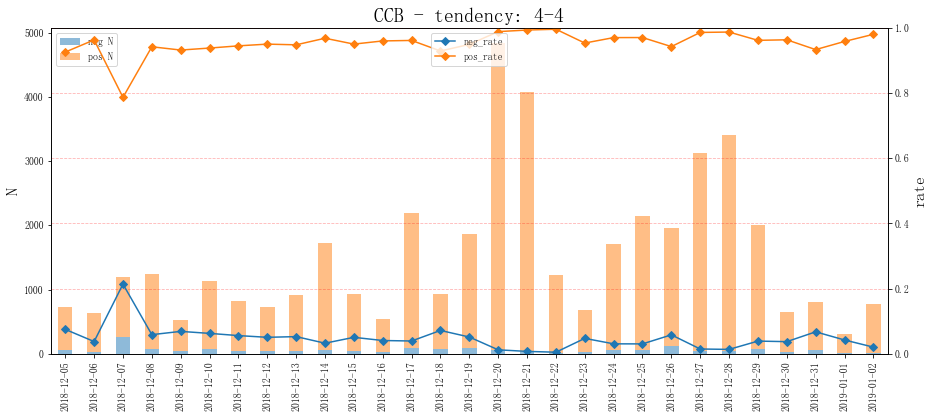

   publishtime  neg   pos   sum  neg_rate  pos_rate
28  2019-01-02   16   766   782     0.020     0.980
27  2019-01-01   13   294   307     0.042     0.958
26  2018-12-31   54   748   802     0.067     0.933
25  2018-12-30   24   620   644     0.037     0.963
24  2018-12-29   78  1925  2003     0.039     0.961


In [124]:
plot_tend(tend_count_4[(tend_count_4['type'] == '建行北分')&(tend_count_4['tendency'] != 1)].drop('type', axis = 1), 
          cbirc_day_thing, "CCB - tendency: 4-4")

### 中国人保

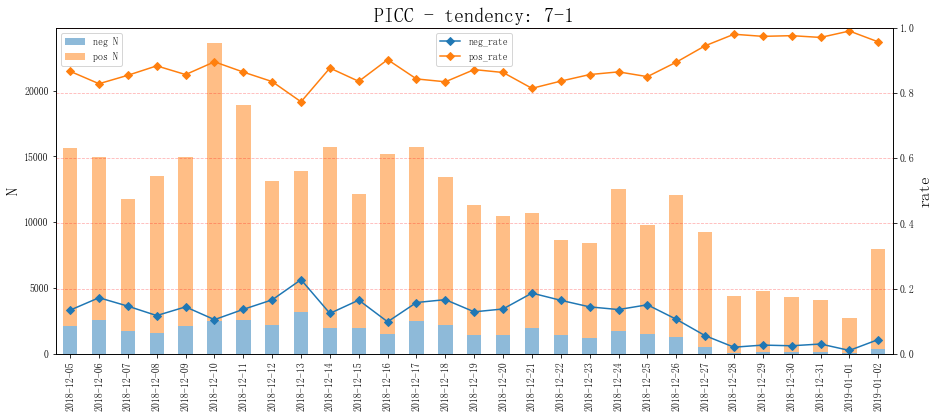

   publishtime  neg   pos   sum  neg_rate  pos_rate
28  2019-01-02  349  7642  7991     0.044     0.956
27  2019-01-01   28  2674  2702     0.010     0.990
26  2018-12-31  122  3942  4064     0.030     0.970
25  2018-12-30  107  4241  4348     0.025     0.975
24  2018-12-29  128  4665  4793     0.027     0.973


In [125]:
plot_tend(tend_count[tend_count['type'] == '中国人保'].drop('type', axis = 1), cbirc_day_thing, "PICC - tendency: 7-1")

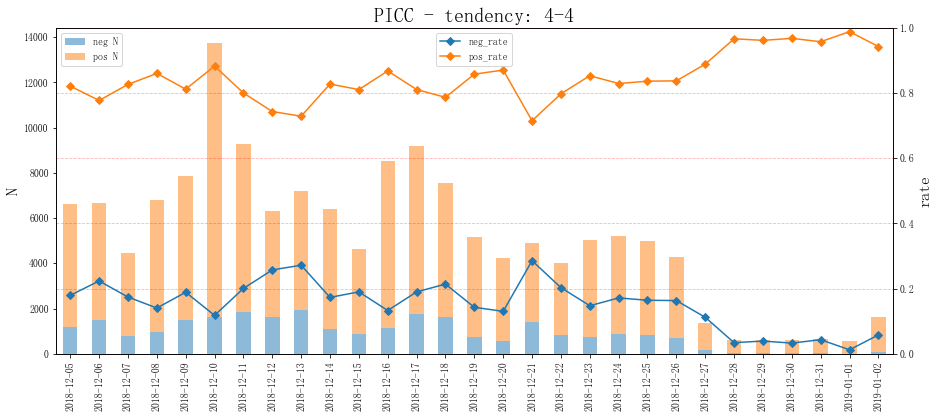

   publishtime  neg   pos   sum  neg_rate  pos_rate
28  2019-01-02   94  1529  1623     0.058     0.942
27  2019-01-01    7   566   573     0.012     0.988
26  2018-12-31   29   642   671     0.043     0.957
25  2018-12-30   20   589   609     0.033     0.967
24  2018-12-29   24   591   615     0.039     0.961


In [126]:
plot_tend(tend_count_4[tend_count_4['type'] == '中国人保'].drop('type', axis = 1), cbirc_day_thing, "PICC - tendency: 4-4")

## 补录和预警
- 20191219
  - 银监会：
  - 保监会：
  - 中国人寿：
  - 建行北分：
  - 中国人保：
- 20191219
  - 银监会：
  - 保监会：
  - 中国人寿：
  - 建行北分：
  - 中国人保：

### 银监会

In [ ]:
# plot_add(cbirc_add[cbirc_add['type'] == '银监会'], cbirc_day_thing, "（银监会）人工补录")

### 保监会

In [ ]:
# plot_add(cbirc_add[cbirc_add['type'] == '保监会'], cbirc_day_thing, "（保监会）人工补录")

### 中国人寿

In [ ]:
plot_add(cbirc_add[cbirc_add['type'] == '中国人寿'], cbirc_day_thing, "（中国人寿）人工补录")

### 建行北分

In [ ]:
plot_add(cbirc_add[cbirc_add['type'] == '建行北分'], cbirc_day_thing, "（建行北分）人工补录")

### 中国人保

In [ ]:
plot_add(cbirc_add[cbirc_add['type'] == '中国人保'], cbirc_day_thing, "（中国人保）人工补录")

In [ ]:
from tqdm import tqdm,trange
from time import sleep

for i in tqdm(range(10), desc='1st loop'):
    for j in trange(100, desc='2nd loop', leave=False):
        sleep(0.01)